# 2nd_ML100days_Notes_Feature_Engineering

## 範例資料集描述 (Demo Dataset Description)
**Demo Dataset 1 - [House Prices: Advanced Regression Techniques](https://reurl.cc/7NM31)**
<img src="img/Kaggle_House Prices_Advanced Regression Techniques.png" width="800">  
* **Competition Description**  
    Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.  
    
    It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.  
    
    
* **Evaluation**  
    Submissions are evaluated on **Root-Mean-Squared-Error (RMSE)** between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)  
<br/>       
    
**Demo Dataset 2 - [New York City Taxi Trip Duration](https://reurl.cc/Aa0K8)**
<img src="img/Kaggle_New York City Taxi Trip Duration.png" width="800">  
 * **Competition Description**  
    In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

   Longtime Kagglers will recognize that this competition objective is similar to the ECML/PKDD trip time challenge we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning.

   We are encouraging you (with cash prizes!) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of kernels that are particularly insightful or valuable to the community.
    
* **Evaluation**  
    The evaluation metric for this competition is **Root Mean Squared Logarithmic Error**. The RMSLE is calculated as:
    $$ \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

## 載入套件 (Import libs.)

In [1]:
# Import libs
import warnings
import os
import copy
import datetime
import math
import pandas as pd
import scipy as sp
import numpy as np

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libs
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from mypackage.preprocessing.MeanEncoder import MeanEncoder  # self-define module

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.feature_selection import RFE, RFECV
from minepy import MINE  # Use 'pip install minepy' under your environment
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import cross_val_score

# Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Other setups
warnings.simplefilter('ignore')
%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=1.2)
np.set_printoptions(suppress=True)

# File path
dir_data = './data/'
dir_img = './img/'

## 前處理 (Preprocessing)

In [2]:
# 讀取 House Price 資料集
house_train = pd.read_csv(dir_data + 'house_train.csv.gz')
house_test = pd.read_csv(dir_data + 'house_test.csv.gz')

# 為了方便作特徵工程，先將訓練資料集以及測試資料集作些處理
train_num = house_train.shape[0]
house_y_train = house_train['SalePrice']
house_test_ids = house_test['Id']
house_train = house_train.drop(['Id', 'SalePrice'] , axis=1)
house_test = house_test.drop(['Id'] , axis=1)
house_df = pd.concat([house_train, house_test]).reset_index(drop=True)

# 檢查訓練資料集以及測試資料集內容
print(f"Shape of training dataset: {house_train.shape}")
print(f"Shape of training dataset: {house_test.shape}")
print(f"Shape of app_df: {house_df.shape}")
display(house_df.iloc[np.r_[0:3, -3:0]])  # 展示頭三筆跟尾三筆資料

# 檢查資料
display(house_df.info())

Shape of training dataset: (1460, 79)
Shape of training dataset: (1459, 79)
Shape of app_df: (2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2918,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

None

In [3]:
# 找出資料集裡所有欄位的資料格式與對應的數量
dtype_df = house_df.dtypes.reset_index()
dtype_df.columns = ['Type_counts', 'Column Type']
dtype_df = dtype_df.groupby('Column Type').aggregate('count').reset_index()
display(dtype_df)

# 確定只有 int64, float64, object 三種類型後，依資料格式將欄名稱分組於三個列表中
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(house_df.dtypes, house_df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)

print(f"{len(int_features)} Integer Features : {int_features}\n")
print(f"{len(float_features)} Float Features : {float_features}\n")
print(f"{len(object_features)} Object Features : {object_features}")

,Column Type,Type_counts
0,int64,25
1,float64,11
2,object,43


25 Integer Features : ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

11 Float Features : ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

43 Object Features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fi

## 特徵工程 (Feature Engineering)
有這麼一句話在業界廣泛流傳：數據和特徵決定了機器學習的上限，而模型和算法只是逼近這個上限而已。那特徵工程到底是什麼呢？顧名思義，特徵工程就是一個利用數據領域的相關知識把原始數據轉變成特徵的過程，這些特徵可以很好的描述這些數據，並且利用它們建立的模型在未知數據上的表現性能可以達到最優(或者接近最佳性能)。

### 補充資料
1. [特征工程到底是什么？](https://reurl.cc/oqGWV)
2. [机器学习之特征工程](https://reurl.cc/mAqQA)
3. [一文读懂特征工程](https://reurl.cc/joq4q)
4. [机器学习特征工程实用技巧大全](https://reurl.cc/k36ln)
5. [特征工程-特征选择、特征表达、特征预处理](https://reurl.cc/joqVM)

<img src="img/特徵工程概論.png" width="1000">  

<img src="img/特徵工程_填補缺值.png" width="800">  
### 填補缺值
在統計中，估算是用替換值替換缺失數據的過程。當替換數據點時，它被稱為**單位插補**；當替換數據點的組成部分時，它被稱為**項目插補**。丟失數據導致三個主要問題：缺少數據會引入大量偏差，使數據的處理和分析更加艱鉅，並降低效率。由於缺失的數據可能會產生分析數據的問題，因此，估算是一種避免陷阱的方法，這些缺陷涉及列表刪除具有缺失值的案例。也就是說，當案例缺少一個或多個值時，大多數情況統計軟件包默認丟棄任何具有缺失值的情況，這可能會引入偏差或影響結果的代表性

**1. 數據缺失的原因** [2]  
   * **無意的**  
     信息被遺漏，比如由於工作人員的疏忽，忘記而缺失；或者由於數據採集器等故障等原因造成的缺失。  
     
     
   * **有意的**  
     有些數據集在特徵描述中會規定將缺失值也作為一種特徵值，這時候缺失值就可以看作是一種特殊的特徵值。  
     
     
   * **不存在**  
     有些特徵屬性根本就是不存在的，比如一個未婚者的配偶名字就沒法填寫，再如一個孩子的收入狀況也無法填寫。 

總而言之，對於造成缺失值的原因，我們需要明確：是因為疏忽或遺漏無意而造成的，還是說故意造成的，或者說根本不存在。只有知道了它的來源，我們才能對症下藥，做相應的處理。  

**2. 數據缺失的類型**  
在對缺失數據進行處理前，了解數據缺失的機制和形式是十分必要的。數據集中不含缺失值的變量稱為完全變量，數據集中含有缺失值的變量稱為不完全變量。而從缺失的分佈來將缺失可以分為完全隨機缺失，隨機缺失和完全非隨機缺失。

   * **完全隨機缺失 (missing completely at random, MCAR)**  
     指的是數據的缺失是完全隨機的，不依賴於任何不完全變量或完全變量，不影響樣本的無偏性，如家庭地址缺失。  
     
     
   * **隨機缺失 (missing at random, MAR)**  
     指的是數據的缺失不是完全隨機的，即該類數據的缺失依賴於其他完全變量，如財務數據缺失情況與企業的大小有關。  
     
     
   * **非隨機缺失 (missing not at random, MNAR)**  
     指的是數據的缺失與不完全變量自身的取值有關，如高收入人群不原意提供家庭收入。

對於隨機缺失和非隨機缺失，直接刪除記錄是不合適的，原因上面已經給出。隨機缺失可以通過已知變量對缺失值進行估計，而非隨機缺失的非隨機性還沒有很好的解決辦法。

**3. 數據缺失的處理方法**
   * **刪除數據** [df.dropna()](https://reurl.cc/y4Eeq)  
     優點為簡單，而缺點則是犧牲了大量的數據，通過減少歷史數據換取完整的信息，這樣可能丟失了很多隱藏的重要信息；當缺失數據比例較大時，特別是缺失數據非隨機分佈時，直接刪除可能會導致數據發生偏離，比如原本的常態分佈變為非常態。
     
  
   * **數據填補** [df.fillna()](https://reurl.cc/D8Vbd)  
     對缺失值的插補大體可分為三種：替換缺失值、擬合缺失值及虛擬變量。替換是通過數據中非缺失數據的相似性來填補，其核心思想是發現相同群體的共同特徵，擬合是通過其他特徵建模來填補，虛擬變量是衍生的新變量代替缺失值。  
ㅤ
     + **替換缺失值**  
ㅤ
       - **平均數** [df.mean()](https://reurl.cc/VqVxy) / 
         **中位數** [df.median()](https://reurl.cc/bypro)  
         對於連續變數特徵且是常態分佈時，使用平均值效果比較好，而當分佈由於異常值存在而不是常態分佈的情況下，使用中位數效果比較好。  
ㅤ
       - **眾數** [sp.stats.mode(df)](https://reurl.cc/v8NNo)  
         對於離散變數特徵而且無法使用已知變量來估計時採用眾數填補會比較恰當。   
ㅤ
       - **最大** [df.max()](https://reurl.cc/jO0Kp) / 
         **最小值** [df.min()](https://reurl.cc/Ead50) / 
         **百分位數** [np.percentile(df)](https://reurl.cc/Gl00Z)  
         其他統計數的填補，端視情況而定。  
ㅤ
       - **熱卡填補**  
         熱卡填充法是在完整數據中找到一個與它最相似的對象，然後用這個相似對象的值來進行填充。通常會找到超出一個的相似對象，在所有匹配對像中沒有最好的，而是從中隨機的挑選一個作為填充值。這個問題關鍵是不同的問題可能會選用不同的標準來對相似進行判定，以及如何制定這個判定標準。該方法概念上很簡單，且利用了數據間的關係來進行空值估計，但缺點在於難以定義相似標準，主觀因素較多。  
ㅤ
       - **K鄰最近距離法**  
         通過K均值的聚類方法將所有樣本進行聚類劃分，然後再通過劃分的種類的均值對各自類中的缺失值進行填補。歸其本質還是通過找相似來填補缺失值。  
ㅤ
     + **擬合缺失值**  
ㅤ
       - **迴歸預測**  
         於完整的數據集，建立回歸方程。對於有缺失值的特徵值，將已知特徵值代入模型來估計未知特徵值，以此估計值來進行填充。  
ㅤ       
       - **極大似然估計**  
         對於極大似然的參數估計實際中常採用的計算方法是期望值最大化。該方法比刪除個案和單值插補更有吸引力，它一個重要前提： 適用於大樣本。有效樣本的數量足夠以保證ML估計值是漸近無偏的並服從常態分佈。但是這種方法可能會陷入局部極值，收斂速度也不是很快，並且計算很複雜，且僅限於線性模型。  
ㅤ
       - **隨機森林**  
         另一種比較常用的擬合方法就是隨機森林，具體實現方式與正常一樣，只是將缺失值作為目標變量即可。        
ㅤ
     + **虛擬變量**  
       虛擬變量其實就是缺失值的一種衍生變量。具體做法是通過判斷特徵值是否有缺失值來定義一個新的二分類變量。比如，特徵為A含有缺失值，我們衍生出一個新的特徵B，如果A中特徵值有缺失，那麼相應的B中的值為1，如果A中特徵值沒有缺失，那麼相應的B中的值為0。  
ㅤ
   * **不處理**  
     補齊處理只是將未知值補以我們的主觀估計值，不一定完全符合客觀事實，在對不完備信息進行補齊處理的同時，我們或多或少地改變了原始的信息系統。而且，對空值不正確的填充往往將新的噪聲引入數據中，使挖掘任務產生錯誤的結果。因此，在許多情況下，我們還是希望在保持原始信息不發生變化的前提下對信息系統進行處理。  
     在實際應用中，一些模型無法應對具有缺失值的數據，因此要對缺失值進行處理。然而還有一些模型本身就可以應對具有缺失值的數據，此時無需對數據進行處理，比如Xgboost。
          
#### **參考資料** 
   1. [Imputation - Wikipedia](https://reurl.cc/6Y2vd)
   2. [【Python数据分析基础】: 数据缺失值处理](https://reurl.cc/3ZVvR)

### - 刪除數據 -

In [4]:
# GrLivArea 沒有缺失值，GarageYrBlt 有缺失值
house_train_GrLivArea = house_train['GrLivArea']
print(f"Before drop NAs, the number of row that GrLivArea isn't NAs: {house_train['GrLivArea'].shape[0]}")
print(f"After drop NAs, the number of row that GrLivArea isn't NAs: {house_train['GrLivArea'].dropna().shape[0]}")
      
house_train_GarageYrBlt = house_train['GarageYrBlt']
print(f"Before drop NAs, the number of row that MasVnrArea isn't NAs: {house_train['GarageYrBlt'].shape[0]}")
print(f"After drop NAs, the number of row that MasVnrArea isn't NAs: {house_train['GarageYrBlt'].dropna().shape[0]}")

Before drop NAs, the number of row that GrLivArea isn't NAs: 1460
After drop NAs, the number of row that GrLivArea isn't NAs: 1460
Before drop NAs, the number of row that MasVnrArea isn't NAs: 1460
After drop NAs, the number of row that MasVnrArea isn't NAs: 1379


 ### - 替換缺失值 - 
 ### 平均數 / 中位數 / 眾數 / 最大值 / 最小值 / 百分位數 

In [5]:
# 計算平均數(函數自動忽略 NAs 進行計算)
print(f"Mean of GarageYrBlt: {house_train['GarageYrBlt'].mean()}")

# 計算中位數(函數自動忽略 NAs 進行計算)
print(f"Median of GarageYrBlt: {house_train['GarageYrBlt'].median()}")

# 計算眾數(函數自動忽略 NAs 進行計算)
print(f"Mode of GarageYrBlt and Count of Mode: {int(sp.stats.mode(house_train['GarageYrBlt'])[0])}, {int(sp.stats.mode(house_train['GarageYrBlt'])[1])}")

# 計算最大值/最小值(函數自動忽略 NAs 進行計算)
print(f"Max Value of GarageYrBlt: {house_train['GarageYrBlt'].max()}")
print(f"Min Value of GarageYrBlt: {house_train['GarageYrBlt'].min()}")

# 計算百分位數(此處剛好是最大/最小值與四分位數，函數不能自動忽略 NAs 進行計算)
for i in range(0,101,25):
    print(f"Q{i} of GarageYrBlt: {np.percentile(house_train['GarageYrBlt'].dropna(), q=i)}")
    
# 補中位數
print(f"Before replace NAs, the number of row that GarageYrBlt is NAs: {sum(house_train['GarageYrBlt'].isnull())}")
print(f"After replace NAs, the number of row that GarageYrBlt is NAs: {sum(house_train['GarageYrBlt'].fillna(house_train['GarageYrBlt'].median()).isnull())}")

Mean of GarageYrBlt: 1978.5061638868744
Median of GarageYrBlt: 1980.0
Mode of GarageYrBlt and Count of Mode: 2005, 65
Max Value of GarageYrBlt: 2010.0
Min Value of GarageYrBlt: 1900.0
Q0 of GarageYrBlt: 1900.0
Q25 of GarageYrBlt: 1961.0
Q50 of GarageYrBlt: 1980.0
Q75 of GarageYrBlt: 2002.0
Q100 of GarageYrBlt: 2010.0
Before replace NAs, the number of row that GarageYrBlt is NAs: 81
After replace NAs, the number of row that GarageYrBlt is NAs: 0


<img src="img/特徵工程_去離群值.png" width="800">  
### 去離群值
在數據科學中，異常值是一個遠離其他觀察的觀察點。的異常值可能在測量是由於變異性，或者它可以指示實驗誤差。異常值可能在任何分佈中偶然發生，但它們通常表示測量誤差或群體具有重尾分佈。在前一種情況下，人們希望丟棄它們或使用對異常值穩健的統計數據，而在後一種情況下，它們表明分佈具有高偏度，並且在使用假定正態分佈的工具或直覺時應該非常謹慎。[1]

**1. 測量異常值** [2,3]
   * **四分位距離法**    
       IQR計算為數據的第75百分位數和第25百分位數之間的差異，IQR可用於通過定義樣本值的限制來識別異常值，這些樣本值是IQR低於第25百分位數或高於第75百分位數的因子 $k$ 。通常採用 $k=1.5$ 而 $k=3$ 或更大可用於識別極端異常值。  
ㅤ
   * **標準偏差法**  
       與平均值的三個標準偏差是在實踐中用於識別高斯分佈的異常值，因此在使用標準偏差法之前要注意的是我們已經假設抽樣樣本為常態分佈，而對於小樣本數的資料集(抽樣偏差)或是很常見的偏態分布母體資料(ex: 所得分布)來說，使用此方法前必須再加以考慮。

**2. 處理異常值** [4,5]
   * **轉換變量**  
       轉換會創建正常的分佈。由於異常值是非常態性的一個原因，通過轉換變量(如 $log$)，可以減少異常值的影響。  
ㅤ
   * **限制異常值(缩尾)**  
       將超出變量特定百分位範圍的數值替換為其特定百分位數值的方法，通常將值更改為下一個最高/最低(非離群值)數字。  
ㅤ
   * **刪除異常值(截尾)**  
       和填補缺失值的概念類似，我們首先必須了解造成異常值的原因，如果異常值是由於錯誤輸入或測量數據造成，則可以刪除異常值。  
ㅤ
   * **分配新值(插值)**  
       應用原有數據信息對離群值賦予一個相對合理的新值的方法，所應用的方法和缺失值部分大同小異。  

最後，具體採用哪種方法來處理離群值需要結合各方法的特點和研究的需要而定。比如，對數轉換對某變量的**全部觀察值**均進行了處理，而其他方法則僅對變量中的離群值進行了處理；插值法利用了原有數據中的**相關性信息**，其他方法則沒有利用這些信息；截尾處理會**減少數據中的樣本量**，其他方法則保留了原有數據的樣本量。在實際操作中應該結合這些特點進行選擇。

#### **參考資料** 
   1. [Outlier - Wikipedia](https://reurl.cc/gpvOL)
   2. [Ways to Detect and Remove the Outliers](https://reurl.cc/OeyZy)
   3. [How to Use Statistics to Identify Outliers in Data](https://reurl.cc/r4xVy)
   4. [離群值! 離群值? 離群值!](https://reurl.cc/Ea9x0)
   5. [Dealing with Outliers](https://reurl.cc/OL1Rv) 

### - 測量異常值 - 
### 四分位距離法 / 標準偏差法

四分位距離法(k = 1.5)
wisker_high:  2747.62
box_high:  1776.75
box_low:  1129.50
wisker_low:  158.62
------------------------------
標準偏差法(sigma = 3)
sigma3_high:  3091.90
sigma3_low: -60.98


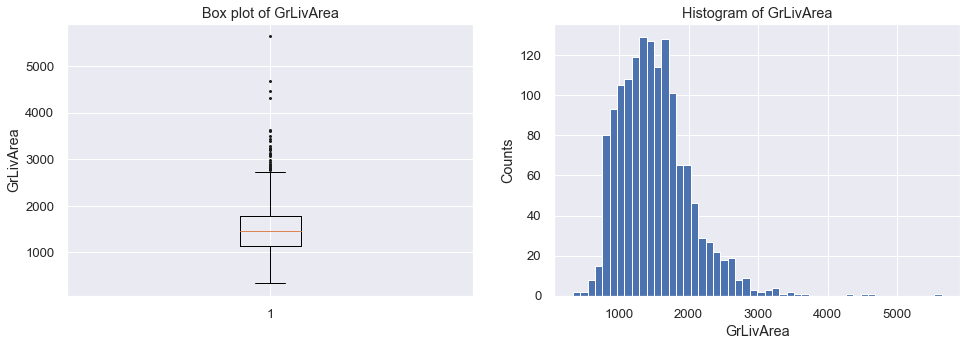

In [6]:
figure, ax = plt.subplots(1,2,figsize=(16,5))

# 四分位距離法(k = 1.5)
plt.subplot(1,2,1)
plt.boxplot(house_train_GrLivArea, sym='k.')
plt.xlabel(''); plt.ylabel('GrLivArea'); plt.title('Box plot of GrLivArea')

q25, q75 = np.percentile(house_train_GrLivArea, 25), np.percentile(house_train_GrLivArea, 75)
iqr, k = q75-q25, 1.5
wisker_low, wisker_high = q25-iqr*k, q75+iqr*k
print(f"四分位距離法(k = {k})")
print(f"wisker_high: {wisker_high: .2f}")
print(f"box_high: {q75: .2f}")
print(f"box_low: {q25: .2f}")
print(f"wisker_low: {wisker_low: .2f}")

print('-'*30)

# 標準偏差法(sigma = 3)
plt.subplot(1,2,2)
plt.hist(house_train_GrLivArea, bins = 50);
plt.xlabel('GrLivArea'); plt.ylabel('Counts'); plt.title('Histogram of GrLivArea')

sigma = 3 
sigma3_high = sigma * house_train_GrLivArea.std() + house_train_GrLivArea.mean()
sigma3_low = -sigma * house_train_GrLivArea.std() + house_train_GrLivArea.mean()
print(f"標準偏差法(sigma = {sigma})")
print(f"sigma3_high: {sigma3_high: .2f}")
print(f"sigma3_low: {sigma3_low: .2f}")

### - 處理異常值 -
### 轉換變量

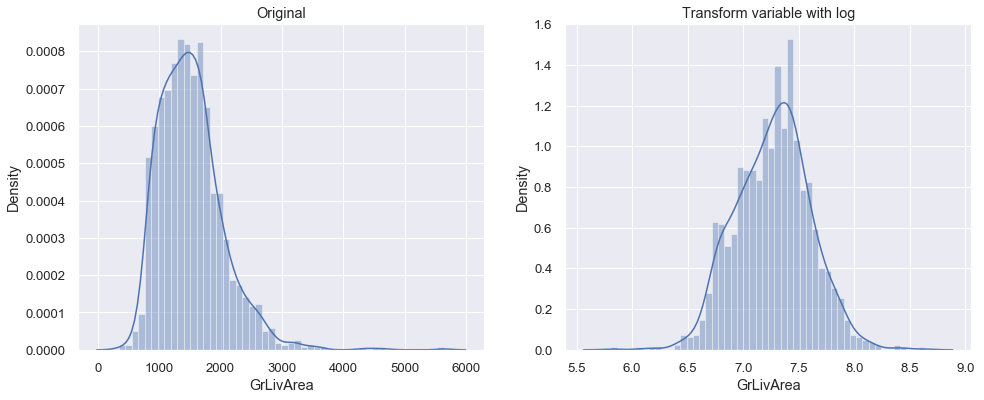

In [7]:
figure, ax = plt.subplots(1,2,figsize=(16,6))

# 不轉換變量
plt.subplot(1,2,1)
sns.distplot(house_train_GrLivArea, bins = 50)
plt.ylabel('Density'); plt.title('Original');

# 轉換變量(對數轉換)
plt.subplot(1,2,2)
sns.distplot(np.log(house_train_GrLivArea), bins = 50)
plt.ylabel('Density'); plt.title('Transform variable with log');

### 限制異常值 / 刪除異常值

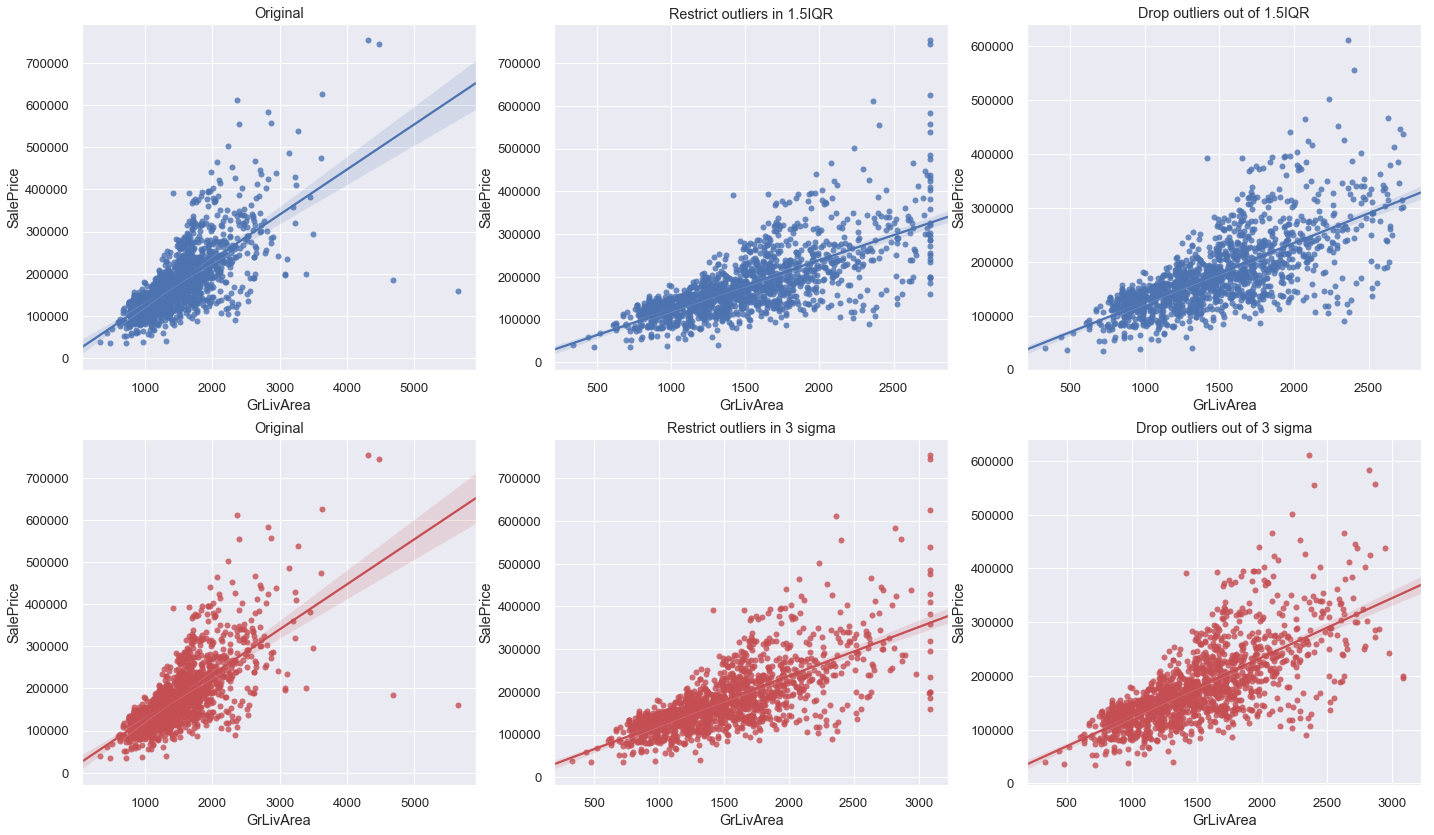

In [8]:
figure, ax = plt.subplots(2,3,figsize=(24,14))

# 不去除離群值
plt.subplot(2,3,1)
sns.regplot(x=house_train_GrLivArea, y=house_y_train)
plt.title('Original');

# 限制 1.5IQR 外的 GrLivArea 離群值
plt.subplot(2,3,2)
house_train_GrLivArea_restrict = house_train_GrLivArea.clip(wisker_low, wisker_high)
house_y_train_restrict = house_y_train.iloc[house_train_GrLivArea_restrict.index]
sns.regplot(x=house_train_GrLivArea_restrict, y=house_y_train_restrict)
plt.title('Restrict outliers in 1.5IQR');

# 捨棄 1.5IQR 外的 GrLivArea 離群值
plt.subplot(2,3,3)
house_train_GrLivArea_drop = house_train['GrLivArea'][(house_train_GrLivArea > wisker_low) & (house_train_GrLivArea < wisker_high)]
house_y_train_drop = house_y_train.iloc[house_train_GrLivArea_drop.index]
sns.regplot(x=house_train_GrLivArea_drop, y=house_y_train_drop)
plt.title('Drop outliers out of 1.5IQR');

# 不去除離群值
plt.subplot(2,3,4)
sns.regplot(x=house_train_GrLivArea, y=house_y_train, color='r')
plt.title('Original');

# 限制 3 個標準差外的 GrLivArea 離群值
plt.subplot(2,3,5)
house_train_GrLivArea_restrict = house_train_GrLivArea.clip(sigma3_low, sigma3_high)
house_y_train_restrict = house_y_train.iloc[house_train_GrLivArea_restrict.index]
sns.regplot(x=house_train_GrLivArea_restrict, y=house_y_train_restrict, color='r')
plt.title('Restrict outliers in 3 sigma');

# 捨棄 3 個標準差外的 GrLivArea 離群值
plt.subplot(2,3,6)
house_train_GrLivArea_drop = house_train['GrLivArea'][(house_train_GrLivArea > sigma3_low) & (house_train_GrLivArea < sigma3_high)]
house_y_train_drop = house_y_train.iloc[house_train_GrLivArea_drop.index]
sns.regplot(x=house_train_GrLivArea_drop, y=house_y_train_drop, color='r')
plt.title('Drop outliers out of 3 sigma');

<img src="img/特徵工程_去偏態.png" width="800">  
### 去偏態   
當離群資料比例例太⾼高，或者平均值沒有代表性時，可以考慮去除偏態(ex: 薪資分布中，高薪群的長尾分布造成平均值不具代表性但是對數去偏後的新分布，平均值就比較具有代表性)。

**1. 偏度與峰度** [1]  
   * **偏度**  [sp.stats.skew](https://reurl.cc/v4Wql)  
     偏度(Skewness)是描述數據分佈形態的統計量，其描述的是某總體取值**分佈的對稱性**。這個統計量同樣需要與正態分佈相比較，偏度為 **$0$** 表示其數據分佈形態與正態分佈的偏斜程度**相同**；偏度**大於 $0$** 表示其數據分佈形態與正態分佈相比為**正偏或右偏**，即有一條長尾巴拖在右邊，數據右端有較多的極端值；偏度**小於 $0$** 表示其數據分佈形態與正態分佈相比為**負偏或左偏**，即有一條長尾拖在左邊，數據左端有較多的極端值。偏度的絕對值數值越大表示其分佈形態的偏斜程度越大。

$$ Skewness = \frac{\frac{1}{n}\sum_{i}^{n}(x_{i}-\overline{x})^{3}}{(\frac{1}{n}\sum_{i}^{n}(x_{i}-\overline{x})^{2})^{\frac{2}{3}}} $$

   * **峰度**  [sp.stats.kurtosis](https://reurl.cc/DL3Zm)  
     峰度(Kurtosis)是描述總體中所有取值**分佈形態陡緩程度**的統計量。這個統計量需要與正態分佈相比較，峰度為 **$0$** 表示該總體數據分佈與正態分佈的陡緩程度**相同**；峰度**大於 $0$** 表示該總體數據分佈與正態分佈相比較為**陡峭**，為尖頂峰；峰度**小於 $0$** 表示該總體數據分佈與正態分佈相比較為**平坦**，為平頂峰。峰度的絕對值數值越大表示其分佈形態的陡緩程度與正態分佈的差異程度越大。 
    

$$ Kurtosis = \frac{\frac{1}{n}\sum_{i}^{n}(x_{i}-\overline{x})^{4}}{(\frac{1}{n}\sum_{i}^{n}(x_{i}-\overline{x})^{2})^{2}}-3 $$


**2. 去偏態方法**
   * **方根去偏** [np.sqrt()](https://reurl.cc/gpQxN)  
   * **對數去偏** [np.log1p()](https://reurl.cc/a8aR9)  
   * **分佈去偏** [sp.stats.boxcox()](https://reurl.cc/a8azZ)  

#### **參考資料** 
   1. [峰度（Kurtosis）和偏度（Skewness）](https://reurl.cc/0lpkM)
   2. [峰度系数和偏度系数在量化交易领域中的作用有哪些？](https://reurl.cc/9LppO)

### - 偏度與峰度 -
### 偏度 / 峰度

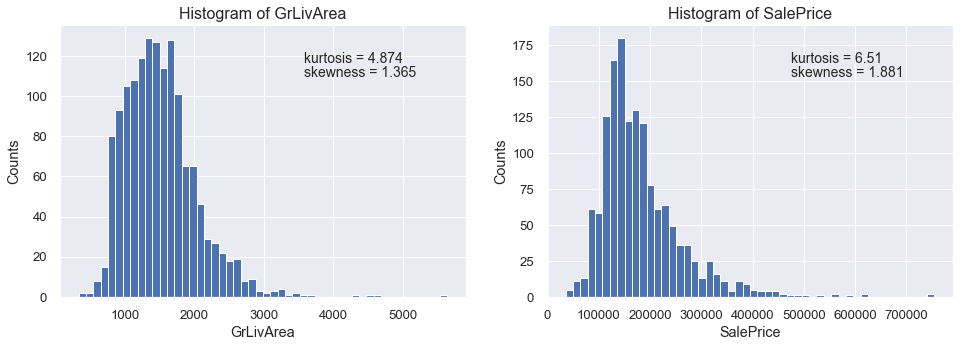

In [9]:
figure, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.flatten()

# 觀察 GrLivArea 的偏度與峰度
kurtosis = round(sp.stats.kurtosis(house_train_GrLivArea), 3)
skewness = round(sp.stats.skew(house_train_GrLivArea), 3)

plt.subplot(1,2,1)
plt.hist(house_train_GrLivArea, bins = 50);
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[0].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[0].transAxes);
plt.xlabel('GrLivArea'); plt.ylabel('Counts'); plt.title('Histogram of GrLivArea', fontsize=16);


# 觀察 SalePrice 的偏度與峰度
kurtosis = round(sp.stats.kurtosis(house_y_train), 3)
skewness = round(sp.stats.skew(house_y_train), 3)

plt.subplot(1,2,2)
plt.hist(house_y_train, bins = 50)
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[1].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[1].transAxes);
plt.xlabel('SalePrice'); plt.ylabel('Counts'); plt.title('Histogram of SalePrice', fontsize=16);

### - 去偏態方法 -
### 方根去偏 / 對數去偏 / 分佈去偏

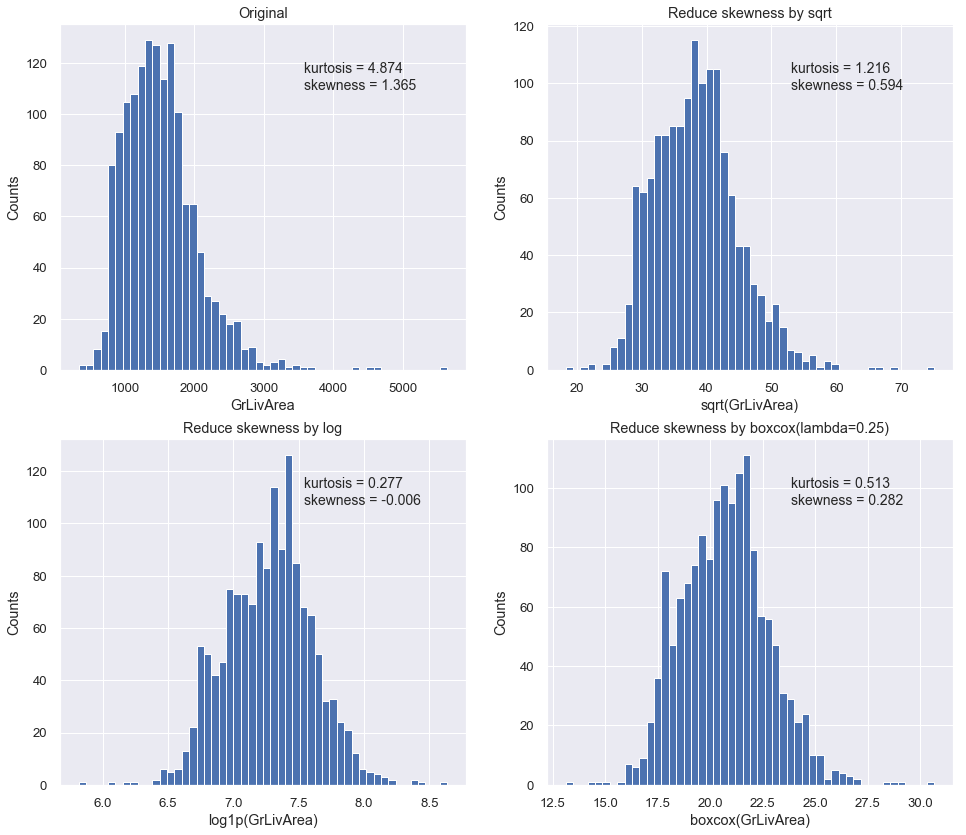

In [10]:
figure, ax = plt.subplots(2,2,figsize=(16,14))
ax = ax.flatten()

# 不去偏
kurtosis = round(sp.stats.kurtosis(house_train_GrLivArea), 3)
skewness = round(sp.stats.skew(house_train_GrLivArea), 3)

plt.subplot(2,2,1)
plt.hist(house_train_GrLivArea, bins = 50)
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[0].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[0].transAxes);
plt.xlabel('GrLivArea'); plt.ylabel('Counts'); plt.title('Original');


# 方根去偏
house_train_GrLivArea_sqrt = np.sqrt(house_train_GrLivArea.values)
kurtosis = round(sp.stats.kurtosis(house_train_GrLivArea_sqrt), 3)
skewness = round(sp.stats.skew(house_train_GrLivArea_sqrt), 3)

plt.subplot(2,2,2)
plt.hist(house_train_GrLivArea_sqrt, bins = 50)
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[1].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[1].transAxes);
plt.xlabel('sqrt(GrLivArea)'); plt.ylabel('Counts'); plt.title('Reduce skewness by sqrt');


# 對數去偏
house_train_GrLivArea_log = np.log1p(house_train_GrLivArea.values)
kurtosis = round(sp.stats.kurtosis(house_train_GrLivArea_log), 3)
skewness = round(sp.stats.skew(house_train_GrLivArea_log), 3)

plt.subplot(2,2,3)
plt.hist(house_train_GrLivArea_log, bins = 50)
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[2].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[2].transAxes);
plt.xlabel('log1p(GrLivArea)'); plt.ylabel('Counts'); plt.title('Reduce skewness by log');


# 分佈去偏
house_train_GrLivArea_boxcox = sp.stats.boxcox(house_train_GrLivArea.values, lmbda=0.25)
kurtosis = round(sp.stats.kurtosis(house_train_GrLivArea_boxcox), 3)
skewness = round(sp.stats.skew(house_train_GrLivArea_boxcox), 3)

plt.subplot(2,2,4)
plt.hist(house_train_GrLivArea_boxcox, bins = 50)
plt.text(x=0.6, y=0.85, s='kurtosis = '+str(kurtosis), fontsize=14, 
         horizontalalignment='left', verticalalignment='bottom', transform = ax[3].transAxes);
plt.text(x=0.6, y=0.8, s='skewness = '+str(skewness), fontsize=14,
         horizontalalignment='left', verticalalignment='bottom', transform = ax[3].transAxes);
plt.xlabel('boxcox(GrLivArea)'); plt.ylabel('Counts'); plt.title('Reduce skewness by boxcox(lambda=0.25)');

<img src="img/特徵工程_特徵縮放.png" width="800">  
### 特徵縮放
將數據按比例縮放，使之落入一個小的特定區間。在某些比較和評價的指標處理中經常會用到，去除數據的單位限制，將其轉化為無量綱的純數值，便於不同單位或量級的指標能夠進行比較和加權。

在數據分析之前，我們通常需要先將數據標準化，利用是統計數據的指數化處理包括**數據同趨化**處理和**無量綱化**處理兩個方面。數據同趨化處理主要解決**不同性質**數據問題，對不同性質指標直接加總不能正確反映不同作用力的綜合結果，須先考慮改變逆指標數據性質，使所有指標對測評方案的作用力同趨化，再加總才能得出正確結果。數據無量綱化處理主要解決數據的**可比性**。經過上述標準化處理，原始數據均轉換為無量綱化指標測評值，即各指標值都處於同一個數量級別上，可以進行綜合測評分析。從經驗上說，歸一化是讓不同維度之間的特徵在數值上有一定比較性，可以大大提高分類器的準確性。[1]  

**1. 特徵縮放好處**  
<img src="img/特徵縮放.jpg" width="600">  
   * **提升模型的收斂速度**  
     如上圖，未進行縮放者會得到一個窄長橢圓形的損失函數，這種損失函數會導致在梯度下降時耗費時間疊代，相比之下，進行縮放者會得到正圓形的損失函數。  
     
     
   * **提升模型的精度**  
     另一好處是提高精度，這在涉及到一些距離計算的算法時效果顯著，比如算法要計算歐氏距離，上圖中兩變數的取值範圍差異太大，導致距離的影響力不同，所以就會造成精度的損失。  
    
  
**2. 特徵縮放方法**  
歸一化轉換容易受到極端值影響，而標準化則不會，因此在使用歸一化前必須去除極端值，若樣本太小或是其他原因造成無法捨棄極端值則需要考慮改用標準化或是採用特徵縮放也不會影響結果的模型。此外，假定數值為均勻分佈，適合採用歸一化平衡特徵；假定數值為常態分佈，則適合採用標準化平衡特徵。
<img src="img/Standardization vs Normalization.png" width="700">  
ㅤ
* **欄縮放(特徵內)**  
ㅤ
     * **歸一化 (Normalization)**  
ㅤ
         + **$[0,1]$ Norm** [MinMaxScaler(feature_range=(0, 1)).fit_transform(df)](https://reurl.cc/y47MM)
           $$ x^{norm}_{i}\:\:=\:\frac{x_{i}-x_{min}}{x_{max}-x_{min}} $$
         + **$[-1,1]$ Norm** [MinMaxScaler(feature_range=(-1, 1)).fit_transform(df)](https://reurl.cc/y47MM)
           $$ x^{norm}_{i}\:\:=\:2(\frac{x_{i}-x_{min}}{x_{max}-x_{min}}-0.5) $$  
         + **$[0,1]$ Norm (for pixel)**
           $$ x^{norm}_{i}\:\:=\:\frac{x_{i}}{255} $$  
ㅤ
     * **標準化 (Standardization)** [StandardScaler().fit_transform(df)](https://reurl.cc/8Lj5y)
       $$ x^{std}_{i}\:\:=\:\frac{x_{i}-\mu_{x}}{\sigma_{x}} $$  
* **列縮放(特徵間)**  
ㅤ
     * **歸一化 (Normalization)** [Normalizer(norm='l2').fit_transform(df)](https://reurl.cc/OojAy) 
       $$ x^{\ell2\: norm}_{i}\:\:=\: \frac{x_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}} $$  
**3. 特徵縮放適用模型**
   * **非樹狀模型**  
     基於參數的模型或基於距離的模型，如線性迴歸, 羅吉斯迴歸, 類神經...等，特徵縮放後對預測**會**有影響。  
     
   * **樹狀模型**  
     基於樹的模型，如決策樹, 隨機森林林, 梯度提升樹...等，特徵縮放後對預測**不會**有影響。

#### **參考資料** 
   1. [数据标准化/归一化normalization](https://reurl.cc/5EA6v)
   2. [Is it a good practice to always scale/normalize data for machine learning?](https://reurl.cc/Zz60W)
   3. [Feature Scaling with scikit-learn](https://reurl.cc/QoZ6O)

[Original]

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

[Normalized with Z-transform]

count    1.460000e+03
mean    -1.277517e-16
std      1.000343e+00
min     -2.249120e+00
25%     -7.347485e-01
50%     -9.797004e-02
75%      4.974036e-01
max      7.855574e+00
Name: GrLivArea, dtype: float64

[Normalized to 0 ~ 1]

count    1460.000000
mean        0.222582
std         0.098998
min         0.000000
25%         0.149868
50%         0.212886
75%         0.271807
max         1.000000
Name: GrLivArea, dtype: float64

[Normalized to -1 ~ 1]

count    1460.000000
mean       -0.554837
std         0.197996
min        -1.000000
25%        -0.700264
50%        -0.574228
75%        -0.456387
max         1.000000
Name: GrLivArea, dtype: float64


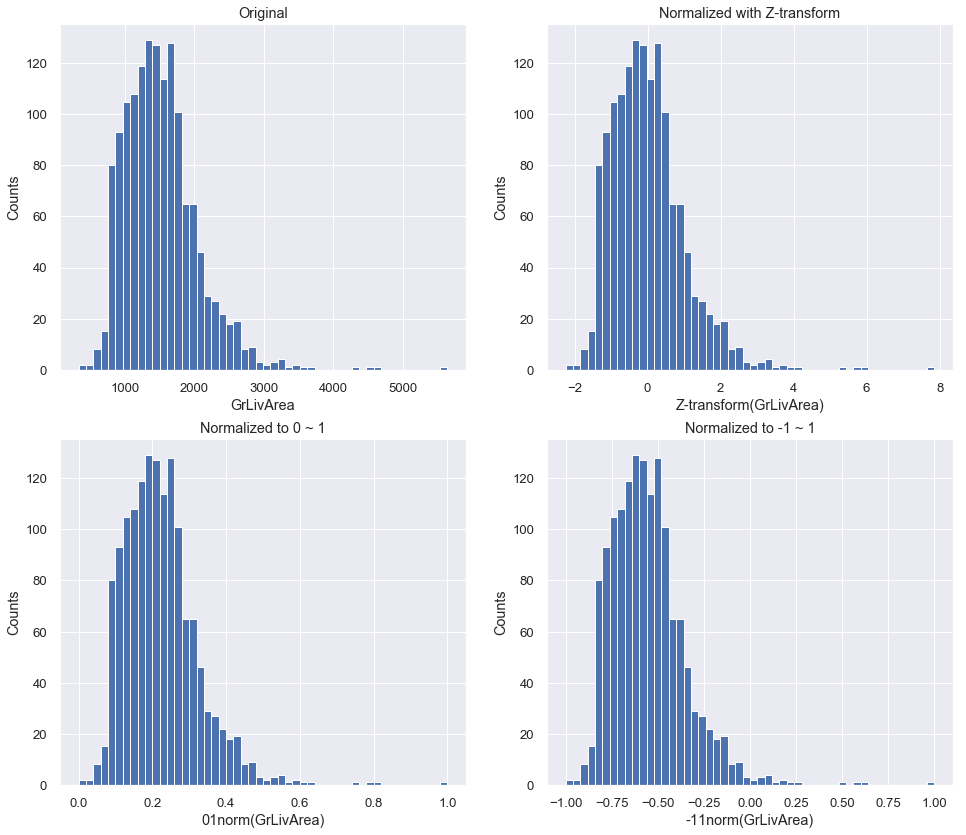

In [11]:
# 不使用套件做特徵縮放
figure, ax = plt.subplots(2,2,figsize=(16,14))

plt.subplot(2,2,1)
plt.hist(house_train_GrLivArea, bins=50)
plt.xlabel('GrLivArea'); plt.ylabel('Counts'); plt.title('Original')

plt.subplot(2,2,2)
house_train_GrLivArea_Znorm = (house_train_GrLivArea - np.nanmean(house_train_GrLivArea)) / (np.nanstd(house_train_GrLivArea))
plt.hist(house_train_GrLivArea_Znorm, bins=50)
plt.xlabel('Z-transform(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized with Z-transform')

plt.subplot(2,2,3)
house_train_GrLivArea_01norm = (house_train_GrLivArea - min(house_train_GrLivArea)) / (max(house_train_GrLivArea) - min(house_train_GrLivArea))
plt.hist(house_train_GrLivArea_01norm, bins=50)
plt.xlabel('01norm(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized to 0 ~ 1')

plt.subplot(2,2,4)
house_train_GrLivArea_11norm = 2 * ((house_train_GrLivArea - min(house_train_GrLivArea)) / (max(house_train_GrLivArea) - min(house_train_GrLivArea)) - 0.5)
plt.hist(house_train_GrLivArea_11norm, bins=50)
plt.xlabel('-11norm(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized to -1 ~ 1');

print('[Original]\n')
print(house_train_GrLivArea.describe())

print('\n[Normalized with Z-transform]\n')
print(house_train_GrLivArea_Znorm.describe())

print('\n[Normalized to 0 ~ 1]\n')
print(house_train_GrLivArea_01norm.describe())

print('\n[Normalized to -1 ~ 1]\n')
print(house_train_GrLivArea_11norm.describe())

[Original]

         GrLivArea
count  1460.000000
mean   1515.463699
std     525.480383
min     334.000000
25%    1129.500000
50%    1464.000000
75%    1776.750000
max    5642.000000

[Normalized with Z-transform]

                  0
count  1.460000e+03
mean  -1.277517e-16
std    1.000343e+00
min   -2.249120e+00
25%   -7.347485e-01
50%   -9.797004e-02
75%    4.974036e-01
max    7.855574e+00

[Normalized to 0 ~ 1]

                 0
count  1460.000000
mean      0.222582
std       0.098998
min       0.000000
25%       0.149868
50%       0.212886
75%       0.271807
max       1.000000

[Normalized to -1 ~ 1]

                 0
count  1460.000000
mean     -0.554837
std       0.197996
min      -1.000000
25%      -0.700264
50%      -0.574228
75%      -0.456387
max       1.000000


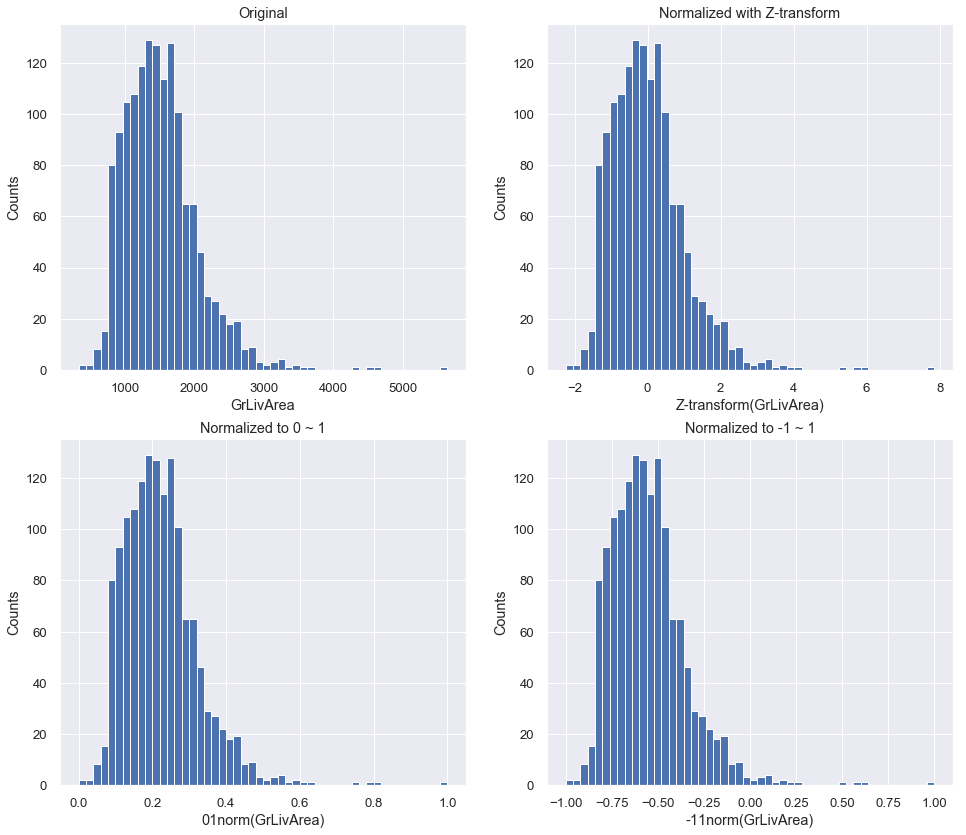

In [12]:
# 使用套件做特徵縮放(Scaler input:DataFrame; output:np array)
house_train_GrLivArea = pd.DataFrame(house_train_GrLivArea)
figure, ax = plt.subplots(2,2,figsize=(16,14))

plt.subplot(2,2,1)
plt.hist(house_train_GrLivArea.values, bins=50);
plt.xlabel('GrLivArea'); plt.ylabel('Counts'); plt.title('Original')

plt.subplot(2,2,2)
house_train_GrLivArea_Znorm = StandardScaler().fit_transform(house_train_GrLivArea)
plt.hist(house_train_GrLivArea_Znorm, bins=50);
plt.xlabel('Z-transform(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized with Z-transform')

plt.subplot(2,2,3)
house_train_GrLivArea_01norm = MinMaxScaler(feature_range=(0,1)).fit_transform(house_train_GrLivArea)
plt.hist(house_train_GrLivArea_01norm, bins=50);
plt.xlabel('01norm(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized to 0 ~ 1')

plt.subplot(2,2,4)
house_train_GrLivArea_11norm = MinMaxScaler(feature_range=(-1,1)).fit_transform(house_train_GrLivArea)
plt.hist(house_train_GrLivArea_11norm, bins=50);
plt.xlabel('-11norm(GrLivArea)'); plt.ylabel('Counts'); plt.title('Normalized to -1 ~ 1');

print('[Original]\n')
print(house_train_GrLivArea.describe())

print('\n[Normalized with Z-transform]\n')
print(pd.DataFrame(house_train_GrLivArea_Znorm).describe())

print('\n[Normalized to 0 ~ 1]\n')
print(pd.DataFrame(house_train_GrLivArea_01norm).describe())

print('\n[Normalized to -1 ~ 1]\n')
print(pd.DataFrame(house_train_GrLivArea_11norm).describe())

<img src="img/特徵工程_類別特徵.png" width="800">  
### 類別特徵
統計學中的變量指的是研究對象的特徵，我們有時也稱為屬性，例如身高、性別等。每個變量都有變量值，變量值就是我們分析的內容，它是沒有含義的，只是一個參與計算的數字，所以我們主要關注變量的類型，不同的變量類型有不同的分析方法。而**類別特徵**就是描述事物**特性**的變量，目的是將事物區分成互不相容的不同組別，變量值多為文字或符號，在分析時，需要轉化為特定含義的數字。[1]  

**1. 分類** [1]
   * **有序類別特徵**  
     描述事物**等級**或**順序**，變量值可以是數值型或字符型，可以進而比較優劣，如喜歡的程度可分為很喜歡、一般、不喜歡。  
     

   * **無序類別特徵**  
     取值之間**沒有順序差別**，僅做分類，又可分為二分類類別特徵和多分類類別特徵，二分類類別特徵是指將全部數據分成兩個類別，如男、女，對、錯，陰、陽等，二分類類別特徵是一種特殊的分類變量，有其特有的分析方法；多分類類別特徵是指兩個以上類別，如血型分為A、B、AB、O。

**2. 處理方法**  
   * **標籤編碼**  [df.map()](https://reurl.cc/KLoQM) / [LabelEncoder()](https://reurl.cc/z4kNa)  
     標籤編碼是用來對分類型特徵值進行編碼，實際上就是將 $n$ 種類別編碼為從 $0$ 到 $n-1$ 的整數，雖然能夠節省內存和降低算法的運行時間，但是隱含了一個假設：不同的類別之間，存在一種順序關係。舉例來說，比如有[狗, 貓, 狗, 老鼠, 貓]的一筆資料，使用標籤編碼會將其轉換為[1, 2, 1, 3, 2]，但在此就會產生序列性上的問題：狗和老鼠的平均值是貓，這顯然不合理也沒有意義，因此在使用標籤編碼時，原特徵就必須有**遞移性**才行。[2]  


   * **獨熱編碼**  [df.get_dummies(df)](https://reurl.cc/OLoED) / [OneHotEncoder()](https://reurl.cc/0le6x)  
     編碼的概念是將離散特徵的取值映射到了歐式空間，也就是空間中的某個點就是離散特徵的某個取值，又因為大部分的模型算法是基於向量空間中的度量來進行計算的(如回歸，分類，聚類等機器學習算法中就是使用了歐式空間的距離計算相似度)，而獨熱編碼就是在映射的過程中強迫每個資料點到原點的**距離相等**，如此就不會使無序關係的變量取值因為變量轉換而產生有序關係才會採取的手段。  
     
     將離散型特徵進行獨熱編碼的作用，是為了讓距離計算更合理並且使原本線性不可分的特徵，經過投影到高維之後變得可分，不過當類別的數量很多時，特徵空間會變得非常大(高維稀疏矩陣)，因此需要龐大的記憶空間與計算時間，在這種情況下，通常又會搭配PCA來減少維度；但如果特徵不用獨熱編碼就可以很合理的計算出距離或是問題只是單純的線性可分系統，那麼就直接採用標籤編碼就可以了。此外，有些基於樹的算法在處理變量時，並不是基於向量空間度量，數值只是個類別符號，無序列關係，所以不用進行獨熱編碼，更深入來討論，其實獨熱編碼對於樹模型來說就只是增加樹的深度罷了。  
     
     總結來說，獨熱編碼解決了分類器不好處理屬性數據的問題，在一定程度上也起到了擴充特徵的作用。但在特徵**重要性高**且可能**值較少**或是採用**非樹狀模型**時，才應該考慮使用。[2]


   * **均值編碼** [MeanEncoder()](https://reurl.cc/eA95K)  
     定性特徵的基數(cardinality)指的是這個定性特徵所有可能的不同值的數量。在高基數的定性特徵(如：電子郵件域名、城市名、家庭住址等...)面前，標籤編碼雖然只需要一列，但是每個自然數都具有不同的重要意義，對於預測目標而言**線性不可分**，在使用簡單模型的情況下容易欠擬合，無法完全捕獲不同類別之間的區別；反之若是使用複雜模型則容易在其他地方過擬合。而獨熱編碼高基數定性特徵，必然產生上萬列的稀疏矩陣，易消耗大量內存和訓練時間，除非算法本身有相關優化否則這些數據編碼的方法往往得不到令人滿意的結果。

     而均值編碼(mean encoding)，就是針對**高基數類別**特徵的有監督編碼。當一個類別特徵列包括了極多不同類別時可以採用。和標籤編碼相比，均值編碼提升了預測的精確度；和獨熱編碼相比，節省內存及減少算法計算時間。但它也有缺點，就是容易過擬合(因為提供了大量數據)，所以使用時要配合適當的正則化技術，如**交叉驗證**、**均值編碼平滑化**及**擴展均值**等方法。[3,4,5]  
<img src="img/均值編碼平滑化.png" width="750">  


   * **群聚編碼**  
     類似均值編碼的概念，只是群聚編碼是對**其他數值型特徵**取平均值作為編碼，而均值編碼則是對**目標值**。由於群聚編碼非對目標值做處理，所以過擬合情況較小，所以也就不用再做均值的平滑化。此外，群聚編碼像特徵的性質描寫，因此也可以取其他統計值，如中位數、眾數、最大值、最小值、次數...等，端以領域知識決定其合理性。


   * **計數編碼**  
     如果類別的預測目標均值與類別筆數呈**正相關 / 負相關**，也可以將筆數本身當成特徵，如自然語言處理時，字詞的計數編碼又稱詞頻，是一個很重要的特徵。  
     

   * **合併編碼**  
     在類別特徵列裡，有時會有一些類別，在訓練集和測試集中總共只出現**一次**，例如特別偏僻的郊區地址。此時，保留其原有的標籤編碼意義不大，不如將所有頻數為 $1$ 的類別合併到同一個新的類別下。
     
     
   * **雜湊編碼** [hash()](https://reurl.cc/q6d40)  
     哈希算法並不是一個特定的算法而是一類算法的統稱。哈希算法也叫散列算法，一般來說滿足這樣的關係： $hash(data)=key$ ，輸入任意長度的 $data$ 數據，經過哈希算法處理後輸出一個固定長的數據 $key$ ，同時這個過程是不可逆的，無法由 $key$ 逆推出 $data$ ，如果是一個  $data$ 數據集，經過哈希算法處理後得到 $key$ 的數據集，然後將 $keys$ 與原始數據進行一一映射就得到了一個哈希表。一般來說哈希表 $H$ 符合 $H[key]=data$ 這種形式。哈希表的好處是當原始數據較大時，我們可以用哈希算法處理得到定長的哈希值 $key$ ，那麼這個 $key$ 相對原始數據要小得多。我們就可以用這個較小的數據集來做索引，達到快速查找的目的。因此在面對高基數類別變量時，就可以用特徵哈希法編碼的方式將原始的**高維特徵向量壓縮成較低維特徵向量，且盡量不損失原始特徵的表達能力**。  
     
但是哈希算法有一個問題，就是哈希值是一個有限集合，而輸入數據則可以是無窮多個。那麼建立一對一關係明顯是不現實的。所以 "碰撞" (不同的輸入數據對應了相同的哈希值)是必然會發生的，所以一個成熟的哈希算法會有較好的抗衝突性。同時在實現哈希表的結構時也要考慮到哈希衝突的問題。  
     

而有一份博客做過這個實驗，發現特徵哈希法可以降低特徵數量，從而加速算法訓練與預測過程，以及降低內存消耗；但代價是通過哈希轉換後學習的模型變得很難檢驗，我們很難對訓練出的模型參數做出合理解釋。特徵哈希法的另一個問題是它會把多個原始特徵哈希到相同的位置上，出現哈希裡的碰撞現象。但實際實驗表明這種碰撞現象對算法的精度影響很小。[6]

#### **參考資料** 
   1. [数据分析中的变量分类](https://reurl.cc/7LNgk)
   2. [OneHotEncoder独热编码和 LabelEncoder标签编码](https://reurl.cc/NL8mn)
   3. [平均数编码：针对高基数定性特征（类别特征）的数据预处理/特征工程](https://reurl.cc/x4RNE)
   4. [Kaggle前1%经验：ML竞赛中常被忽视的特征工程技术](https://reurl.cc/p4Gp4)
   5. [挑战Kaggle笔记：高级特征工程（上篇）](https://reurl.cc/x4Rob)
   6. [特征哈希编码及哈希算法](https://reurl.cc/eAx9b)

### - 處理方法 -
### 標籤編碼

In [13]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle']
print('Before label encoding')
display(house_df_unencode.head(10))

# 定義 mapping 規則
HouseStyle_mapping = {'2Story':0, '1Story':1, '1.5Fin':2, '1.5Unf':3, 'SFoyer':4, 'SLvl':5, '2.5Unf':6, '2.5Fin':7} 

# Label encode by df.map()
house_df_encode = house_df_unencode.copy()
house_df_encode['HouseStyle_Label'] = house_df['HouseStyle'].map(HouseStyle_mapping)

print('After label encoding')
display(house_df_encode.head(10))

Before label encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story
5,1.5Fin
6,1Story
7,2Story
8,1.5Fin
9,1.5Unf


After label encoding


,HouseStyle,HouseStyle_Label
0,2Story,0
1,1Story,1
2,2Story,0
3,2Story,0
4,2Story,0
5,1.5Fin,2
6,1Story,1
7,2Story,0
8,1.5Fin,2
9,1.5Unf,3


In [14]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle'].fillna('None')  # LabelEncoder 不能在欄裡有 NAs 作用
print('Before label encoding')
display(house_df_unencode.head(10))

# 對 HouseStyle 作標籤編碼
house_df_encode = house_df_unencode.copy()
lb_encode = LabelEncoder()
house_df_encode['HouseStyle_Label'] = lb_encode.fit_transform(house_df_unencode['HouseStyle'])

print('After label encoding')
display(house_df_encode.head(10))

Before label encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story
5,1.5Fin
6,1Story
7,2Story
8,1.5Fin
9,1.5Unf


After label encoding


,HouseStyle,HouseStyle_Label
0,2Story,5
1,1Story,2
2,2Story,5
3,2Story,5
4,2Story,5
5,1.5Fin,0
6,1Story,2
7,2Story,5
8,1.5Fin,0
9,1.5Unf,1


In [15]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[object_features].fillna('None')  # LabelEncoder 不能在欄裡有 NAs 作用
print('Before label encoding')
display(house_df_unencode.head(5))

# 對所有類別特徵作標籤編碼
lb_encode = LabelEncoder()
for c in object_features:
    house_df_encode[c] = lb_encode.fit_transform(house_df_unencode[c])
    house_df_encode = house_df_encode.rename(columns={c:c+'_Label'})
    
print('After label encoding')
display(house_df_encode.head(5))

Before label encoding


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


After label encoding


,MSZoning_Label,Street_Label,Alley_Label,LotShape_Label,LandContour_Label,Utilities_Label,LotConfig_Label,LandSlope_Label,Neighborhood_Label,Condition1_Label,...,GarageType_Label,GarageFinish_Label,GarageQual_Label,GarageCond_Label,PavedDrive_Label,PoolQC_Label,Fence_Label,MiscFeature_Label,SaleType_Label,SaleCondition_Label
0,4,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,9,4
1,4,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,9,4
2,4,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,9,4
3,4,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,9,0
4,4,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,9,4


### 獨熱編碼

In [16]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle'].fillna('None')  # pd.get_dummies 會忽略欄裡的 NAs(不會被歸為一類)
print('Before one-hot encoding')
display(house_df_unencode.head(5))

# One-hot encode by pd.get_dummies(df)
HouseStyle_onehot = pd.get_dummies(house_df_unencode['HouseStyle'], prefix='HouseStyle')
house_df_encode = pd.concat([HouseStyle_onehot, house_df_unencode], axis=1)
print('After one-hot encoding')
display(house_df_encode.head(5))

Before one-hot encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story


After one-hot encoding


,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle
0,0,0,0,0,0,1,0,0,2Story
1,0,0,1,0,0,0,0,0,1Story
2,0,0,0,0,0,1,0,0,2Story
3,0,0,0,0,0,1,0,0,2Story
4,0,0,0,0,0,1,0,0,2Story


In [17]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle'].fillna('None')
print('Before one-hot encoding')
display(house_df_unencode.head(5))

# 將 dataframe 轉成 matrix (column)
HouseStyle_arrary = np.array(house_df_unencode['HouseStyle']).reshape(len(house_df_unencode['HouseStyle']), 1)

# 對 HouseStyle 作獨熱編碼
ohencoder = OneHotEncoder(sparse=False)
HouseStyle_onehot = ohencoder.fit_transform(HouseStyle_arrary)
colname_onehot = np.array(ohencoder.categories_).ravel()  # 將多重 array [..[[x1, x2,...]]..] 解開成 [x1, x2,...]
HouseStyle_df = pd.DataFrame(HouseStyle_onehot, columns=colname_onehot).add_prefix('HouseStyle_')
house_df_encode = pd.concat([HouseStyle_df, house_df_unencode], axis=1)
print('After one-hot encoding')
display(house_df_encode.head(5))

Before one-hot encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story


After one-hot encoding


,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2Story
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1Story
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2Story
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2Story
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2Story


### 均值編碼

In [18]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle'].fillna('None')
print('Before mean encoding')
display(house_df_unencode.head(5))

# 對 HouseStyle 作均值編碼 (用法參考: http://www.jiangdongzml.com/2018/01/31/Catergorical_Attributes/)
meancoder = MeanEncoder(categorical_features=['HouseStyle'], target_type='regression')
house_df_encode = meancoder.fit_transform(house_df_unencode[:train_num], house_y_train)
print('After mean encoding')
display(house_df_encode.head(5))

Before mean encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story


After mean encoding


,HouseStyle,HouseStyle_pred
0,2Story,209562.991597
1,1Story,176355.923211
2,2Story,209562.991597
3,2Story,209562.991597
4,2Story,209562.991597


In [19]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[object_features].fillna('None')
print('Before mean encoding')
display(house_df_unencode.head(5))

# 對所有類別特徵作均值編碼 (用法參考: http://www.jiangdongzml.com/2018/01/31/Catergorical_Attributes/)
meancoder = MeanEncoder(categorical_features=object_features, target_type='regression')
house_df_encode = meancoder.fit_transform(house_df_unencode[:train_num], house_y_train)
house_df_encode = house_df_encode.drop(object_features, axis=1)
print('After mean encoding')
display(house_df_encode.head(5))

Before mean encoding


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


After mean encoding


,MSZoning_pred,Street_pred,Alley_pred,LotShape_pred,LandContour_pred,Utilities_pred,LotConfig_pred,LandSlope_pred,Neighborhood_pred,Condition1_pred,...,GarageType_pred,GarageFinish_pred,GarageQual_pred,GarageCond_pred,PavedDrive_pred,PoolQC_pred,Fence_pred,MiscFeature_pred,SaleType_pred,SaleCondition_pred
0,190301.12743,180916.956148,183173.911253,163349.160377,180109.233716,180754.12425,175535.286047,179852.194545,197715.140351,184002.142572,...,203464.404591,201652.903904,186959.443182,187486.126058,186333.044944,180116.689329,187219.925498,181692.16504,173312.048134,175249.515088
1,190301.12743,180916.956148,183173.911253,163349.160377,180109.233716,180754.12425,182707.432432,179852.194545,237047.869961,144902.492958,...,203464.404591,201652.903904,186959.443182,187486.126058,186333.044944,180116.689329,187219.925498,181692.16504,173312.048134,175249.515088
2,190301.12743,180916.956148,183173.911253,208022.683117,180109.233716,180754.12425,175535.286047,179852.194545,197715.140351,184002.142572,...,203464.404591,201652.903904,186959.443182,187486.126058,186333.044944,180116.689329,187219.925498,181692.16504,173312.048134,175249.515088
3,190301.12743,180916.956148,183173.911253,208022.683117,180109.233716,180754.12425,185758.304124,179852.194545,206982.813953,184002.142572,...,132496.862620,141110.123711,186959.443182,187486.126058,186333.044944,180116.689329,187219.925498,181692.16504,173312.048134,145030.524390
4,190301.12743,180916.956148,183173.911253,208022.683117,180109.233716,180754.12425,182707.432432,179852.194545,340391.888889,184002.142572,...,203464.404591,201652.903904,186959.443182,187486.126058,186333.044944,180116.689329,187219.925498,181692.16504,173312.048134,175249.515088


### 群聚編碼

In [20]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[['HouseStyle', 'GrLivArea']]
house_df_unencode['HouseStyle'] = house_df_unencode['HouseStyle'].fillna('None')
print('Before groupby encoding')
display(house_df_unencode.head(5))


# GrLivArea (數值型特徵) 對 HouseStyle (類別型特徵) 做群聚編碼
mean_df = house_df_unencode.groupby(['HouseStyle'])['GrLivArea'].mean().reset_index()
mode_df = house_df_unencode.groupby(['HouseStyle'])['GrLivArea'].apply(lambda x: x.mode()[0]).reset_index()
median_df = house_df_unencode.groupby(['HouseStyle'])['GrLivArea'].median().reset_index()
temp_df = pd.merge(mean_df, mode_df, how='left', on=['HouseStyle'])
temp_df = pd.merge(temp_df, median_df, how='left', on=['HouseStyle'])
temp_df.columns = ['HouseStyle', 'GrLivArea_Mean', 'GrLivArea_Mode', 'GrLivArea_Median']
house_df_encode = pd.merge(house_df_unencode, temp_df, how='left', on=['HouseStyle'])
print('After groupby encoding')
display(house_df_encode.head(5))

Before groupby encoding


,HouseStyle,GrLivArea
0,2Story,1710
1,1Story,1262
2,2Story,1786
3,2Story,1717
4,2Story,2198


After groupby encoding


,HouseStyle,GrLivArea,GrLivArea_Mean,GrLivArea_Mode,GrLivArea_Median
0,2Story,1710,1856.022936,1092,1779.0
1,1Story,1262,1316.982325,864,1270.0
2,2Story,1786,1856.022936,1092,1779.0
3,2Story,1717,1856.022936,1092,1779.0
4,2Story,2198,1856.022936,1092,1779.0


### 計數編碼

In [21]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = pd.concat([house_df['HouseStyle'].fillna('None')[:train_num], house_y_train], axis=1)
print('Before count encoding')
display(house_df_unencode[['HouseStyle']].head(5))

# 對 HouseStyle 作計數編碼
count_df = house_df_unencode.groupby(['HouseStyle']).size().reset_index()
house_df_encode = pd.merge(house_df_unencode.drop('SalePrice', axis=1), count_df, 
                           on=['HouseStyle'], how='left').rename(columns={0:'HouseStyle_count'})
print('After count encoding')
display(house_df_encode.head(5))

# # 檢查相關性，若夠有正/負相關性則可以作計數編碼
# mean_df = house_df_unencode.groupby(['HouseStyle'])['SalePrice'].mean().reset_index()
# house_df_temp = pd.merge(count_df, mean_df, on='HouseStyle', how='left')
# house_df_temp.columns = ['HouseStyle', 'HouseStyle_count', 'HouseStyle_mean']
# print(f"Corr. between count and mean = {np.corrcoef(house_df_temp['HouseStyle_count'], house_df_temp['HouseStyle_mean'])[0][1]:.2f}")
# display(house_df_temp.sort_values(by=['HouseStyle_count'], ascending=False))

Before count encoding


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story


After count encoding


,HouseStyle,HouseStyle_count
0,2Story,445
1,1Story,726
2,2Story,445
3,2Story,445
4,2Story,445


In [22]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[object_features].fillna('None')
print('Before count encoding')
display(house_df_unencode[object_features].head(5))

# 對所有類別特徵作計數編碼
house_df_encode = house_df_unencode
for c in object_features:
    count_df = house_df_encode.groupby([c]).size().reset_index().rename(columns={0:c+'_count'})
    house_df_encode = pd.merge(house_df_encode, count_df, on=[c], how='left').drop([c], axis=1)

print('After count encoding')
display(house_df_encode.head(5))

Before count encoding


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


After count encoding


,MSZoning_count,Street_count,Alley_count,LotShape_count,LandContour_count,Utilities_count,LotConfig_count,LandSlope_count,Neighborhood_count,Condition1_count,...,GarageType_count,GarageFinish_count,GarageQual_count,GarageCond_count,PavedDrive_count,PoolQC_count,Fence_count,MiscFeature_count,SaleType_count,SaleCondition_count
0,2265,2907,2721,1859,2622,2916,2133,2778,267,2511,...,1723,811,2604,2654,2641,2909,2348,2814,2525,2402
1,2265,2907,2721,1859,2622,2916,85,2778,24,164,...,1723,811,2604,2654,2641,2909,2348,2814,2525,2402
2,2265,2907,2721,968,2622,2916,2133,2778,267,2511,...,1723,811,2604,2654,2641,2909,2348,2814,2525,2402
3,2265,2907,2721,968,2622,2916,511,2778,103,2511,...,779,1230,2604,2654,2641,2909,2348,2814,2525,190
4,2265,2907,2721,968,2622,2916,85,2778,71,2511,...,1723,811,2604,2654,2641,2909,2348,2814,2525,2402


### 合併編碼

In [23]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[object_features].fillna('None')
print('Before combination')
display(house_df_unencode.head(5))

# 對類別特徵計數為 1 者作合併，併成一個新類別 "Others"
house_df_encode = house_df_unencode.copy()
for c in object_features:
    count_df = house_df_encode.groupby([c]).size().reset_index().rename(columns={0:c+'_count'})
    if len(count_df[count_df[c+'_count']==1][c].tolist()) != 0:
        count_1 = count_df[count_df[c+'_count']==1][c].tolist()
        house_df_encode[c] = house_df_encode[c].replace(count_1, 'Others')
print('After combination')
display(house_df_encode.head(5))

# 比較處理前後差異 (以特徵 RoofMatl 作範例)
print('Before combination')
display(house_df_unencode.groupby(['RoofMatl']).size().reset_index().rename(columns={0:c+'_count'}))
print('After combination')
display(house_df_encode.groupby(['RoofMatl']).size().reset_index().rename(columns={0:c+'_count'}))

Before combination


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


After combination


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


Before combination


,RoofMatl,SaleCondition_count
0,ClyTile,1
1,CompShg,2876
2,Membran,1
3,Metal,1
4,Roll,1
5,Tar&Grv,23
6,WdShake,9
7,WdShngl,7


After combination


,RoofMatl,SaleCondition_count
0,CompShg,2876
1,Others,4
2,Tar&Grv,23
3,WdShake,9
4,WdShngl,7


### 雜湊編碼

In [24]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode['HouseStyle'] = house_df['HouseStyle'].fillna('None') 
print('Before combination')
display(house_df_unencode.head(5))

# 對 HouseStyle 作雜湊編碼
house_df_encode = house_df_unencode.copy()
house_df_encode['HouseStyle_Hash'] = house_df_unencode['HouseStyle'].map(lambda x:hash(x) % 10)
display(house_df_encode.head(5))

Before combination


,HouseStyle
0,2Story
1,1Story
2,2Story
3,2Story
4,2Story


,HouseStyle,HouseStyle_Hash
0,2Story,5
1,1Story,6
2,2Story,5
3,2Story,5
4,2Story,5


In [25]:
house_df_unencode = pd.DataFrame()
house_df_encode = pd.DataFrame()

house_df_unencode = house_df[object_features].fillna('None')
print('Before hash encoding')
display(house_df_unencode.head(5))

# 對所有特徵作雜湊編碼，因為為了要確定是緊密(dense)特徵，因此除以10後看餘數
for c in object_features:
    house_df_encode[c+'_Hash'] = house_df_unencode[c].map(lambda x:hash(x) % 10)
print('After hash encoding')
display(house_df_encode.head(5))

Before hash encoding


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


After hash encoding


,MSZoning_Hash,Street_Hash,Alley_Hash,LotShape_Hash,LandContour_Hash,Utilities_Hash,LotConfig_Hash,LandSlope_Hash,Neighborhood_Hash,Condition1_Hash,...,GarageType_Hash,GarageFinish_Hash,GarageQual_Hash,GarageCond_Hash,PavedDrive_Hash,PoolQC_Hash,Fence_Hash,MiscFeature_Hash,SaleType_Hash,SaleCondition_Hash
0,6,4,1,8,2,6,8,9,9,8,...,6,7,1,1,8,1,1,1,0,7
1,6,4,1,8,2,6,8,9,7,0,...,6,7,1,1,8,1,1,1,0,7
2,6,4,1,6,2,6,8,9,9,8,...,6,7,1,1,8,1,1,1,0,7
3,6,4,1,6,2,6,1,9,8,8,...,7,0,1,1,8,1,1,1,0,5
4,6,4,1,6,2,6,8,9,6,8,...,6,7,1,1,8,1,1,1,0,7


<img src="img/特徵工程_時間特徵.png" width="800">  
### 時間特徵
時間序列數據(time series data)是在不同時間上收集到的數據，用於描述現象隨時間變化的情況。時間序列是一種典型的數據，具有隨時間變化的特徵。如何對時序數據加以利用，比如做未來預測，交通擁堵分類等問題。在採用機器學習算法之前，首先需要我們構建特徵。因為大多數時序數據都是單變量或者維度特別少，所以特徵的構建就相當重要。[1]  

**處理方法**  
   * **時間特徵分解** [datetime](https://reurl.cc/N9Ee5)   
     依時間戳記直觀地將原意義分欄處理，或再擴展至更詳細且對人類有意義的特徵，譬如：2014-06-12 03:25:56 可以分解成 {年:2014, 月:6, 日:12, 時:3, 分:25, 秒:56, 周: 2, 星期:4, 季節:夏}。  
     
     
   * **週期循環特徵**  
     利用時間的週期性合成一些重要的特徵，譬如：年週期 - 季節溫度、月週期 - 薪水或經期、周週期 - 工作或消費習慣、日週期 - 生理時鐘，注意到週期變量是有循環的特性，因此必須使用$sin(\frac{2\pi x_{t}}{t})$ 或 $cos(\frac{2\pi x_{t}}{t})$ 達成變量轉換。


#### **參考資料**   
   1. [时间序列(time serie)分析系列之时间序列特征(feature)7](https://reurl.cc/rAgnk)
   2. [时间序列(time serie)分析系列之简介1](https://reurl.cc/883aX)
   3. [时间序列分析和预测](https://reurl.cc/ZvGkM)
   4. [时间序列分析](https://reurl.cc/MVAQk)
   5. [pandas小记：pandas时间序列分析和处理Timeseries](https://reurl.cc/pAgjZ)

In [26]:
# 讀取 new york city taxi fare 資料集
taxi_train = pd.read_csv(dir_data + 'taxi_data1.csv')
taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2011-10-21 23:54:10 UTC,-73.990580,40.761071,-73.981128,40.758634,2
1,12.0,2015-02-03 10:42:03 UTC,-73.988403,40.723431,-73.989647,40.741695,1
2,6.5,2014-03-16 18:58:58 UTC,-74.015785,40.715110,-74.012029,40.707888,2
3,6.5,2009-06-13 16:10:54 UTC,-73.977322,40.787275,-73.958030,40.778838,3
4,11.0,2014-06-12 03:25:56 UTC,-73.989683,40.729717,-73.982490,40.761887,3


### - 處理方法 -
### 時間特徵分解

In [27]:
taxi_train['pickup_datetime'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
taxi_train['pickup_year'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
taxi_train['pickup_month'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
taxi_train['pickup_day'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')
taxi_train['pickup_hour'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%H')).astype('int64')
taxi_train['pickup_minute'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%M')).astype('int64')
taxi_train['pickup_second'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%S')).astype('int64')
taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second
0,4.5,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10
1,12.0,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3
2,6.5,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58
3,6.5,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54
4,11.0,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56


In [28]:
# 當天是星期幾 (非星期 1~7 而是星期 0~6)
taxi_train['pickup_dow'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')

# 當天是一年中的第幾周
taxi_train['pickup_woy'] = taxi_train['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%W')).astype('int64')

taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_dow,pickup_woy
0,4.5,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42
1,12.0,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5
2,6.5,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,10
3,6.5,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23
4,11.0,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23


### 週期循環特徵

In [29]:
# 年週期
def second_delta_year(taxi_train):
    sec_d = (datetime.datetime(taxi_train['pickup_year'], taxi_train['pickup_month'], taxi_train['pickup_day'], 
                               taxi_train['pickup_hour'], taxi_train['pickup_minute'], taxi_train['pickup_second']) -\
             datetime.datetime(taxi_train['pickup_year'], 1, 1, 0, 0, 0)).total_seconds()
    return sec_d

sec_d_year = taxi_train.apply(second_delta_year, axis=1).astype('int64')
taxi_train['year_cycle'] = np.sin(2*np.pi*sec_d_year / (365*24*60*60))


# 月週期
def second_delta_month(taxi_train):
    sec_d = (datetime.datetime(taxi_train['pickup_year'], taxi_train['pickup_month'], taxi_train['pickup_day'], 
                               taxi_train['pickup_hour'], taxi_train['pickup_minute'], taxi_train['pickup_second']) -\
             datetime.datetime(taxi_train['pickup_year'], taxi_train['pickup_month'], 1, 0, 0, 0)).total_seconds()
    return sec_d

sec_d_month = taxi_train.apply(second_delta_month, axis=1).astype('int64')
taxi_train['month_cycle'] = np.sin(2*np.pi*sec_d_month / (taxi_train['pickup_datetime'].dt.daysinmonth*24*60*60))


# 周週期
sec_d_week = taxi_train['pickup_dow']*24*60*60 + taxi_train['pickup_hour']*60*60 + taxi_train['pickup_minute']*60 + taxi_train['pickup_second']
taxi_train['week_cycle'] = np.sin(2*np.pi*sec_d_week / (7*24*60*60))


# 日週期
def second_delta_day(taxi_train):
    sec_d = (datetime.datetime(taxi_train['pickup_year'], taxi_train['pickup_month'], taxi_train['pickup_day'], 
                               taxi_train['pickup_hour'], taxi_train['pickup_minute'], taxi_train['pickup_second']) -\
             datetime.datetime(taxi_train['pickup_year'], taxi_train['pickup_month'], taxi_train['pickup_day'], 0, 0, 0)).total_seconds()
    return sec_d

sec_d_day = taxi_train.apply(second_delta_day, axis=1).astype('int64')
taxi_train['day_cycle'] = np.sin(2*np.pi*sec_d_day / (24*60*60))


taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_dow,pickup_woy,year_cycle,month_cycle,week_cycle,day_cycle
0,4.5,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42,-0.939880,-0.897443,-0.784093,-0.025450
1,12.0,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5,0.544459,0.521708,0.811191,0.333601
2,6.5,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,10,0.960130,-0.058936,0.651799,-0.967083
3,6.5,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23,0.318428,0.468071,-0.288256,-0.888817
4,11.0,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23,0.343301,0.722773,-0.545649,0.782427


<img src="img/特徵工程_特徵組合.png" width="800">  
### 特徵組合
如果需要用到多個特徵作為輸入，則需要將兩個或多個特徵相乘或求笛卡爾積形成合成特徵，這種做法就叫特徵組合，而恰當的使用特徵組合可以增強機器學習模型的預測能力，在數學上，特徵組合其實就是藉由**空間轉換**使得在原空間需以**非線性關係求解**的問題在新空間內可以用**線性關係求解**。  

**處理方法**  
   * **連續特徵組合**  
     特徵組合有無限多種，比如將兩個不同的特徵進行組合或將多個不同的值相乘形成新的特徵組合或是將單個特徵的值求平方的特徵組合，但要怎麼組合出一個具有合理性的特徵則必須依靠**領域知識**或是藉由**EDA**對數據集找出獨特的洞見。
     
     
   * **離散特徵組合** [1,2]  
     機器學習模型經常組合獨熱特徵向量，而特徵組合本質上是一個**笛卡爾積**，因此獨熱特徵向量的特徵組合就可視為一種**邏輯連接**，例如，在兩個特徵的笛卡爾積中，如果同時滿足兩者的條件，則結果為$1$；否則將會是$0$。實際上，一般會先把數據進行離散化處理，再把離散化的結果進行特徵交叉，此時可以獲得更好的數據特徵，離散化處理可以對數據降維，從而極大地簡化計算量。


#### **參考資料**   
   1. [特征组合&特征交叉 (Feature Crosses)](https://reurl.cc/egz3x)
   2. [特征交叉](https://reurl.cc/LgWpy)
   3. [简单高效的组合特征自动挖掘框架](https://reurl.cc/egzOL)

### - 處理方法 -
### 連續特徵組合

In [30]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6372800  # Earth radius in meters
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [31]:
# 將經緯度轉成實際距離
taxi_train['distance_real'] = taxi_train.apply(lambda x: haversine(x['pickup_latitude'], 
                                                                   x['pickup_longitude'], 
                                                                   x['dropoff_latitude'], 
                                                                   x['dropoff_longitude']), axis=1)
taxi_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_dow,pickup_woy,year_cycle,month_cycle,week_cycle,day_cycle,distance_real
0,4.5,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42,-0.939880,-0.897443,-0.784093,-0.025450,841.187374
1,12.0,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5,0.544459,0.521708,0.811191,0.333601,2034.225697
2,6.5,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,10,0.960130,-0.058936,0.651799,-0.967083,863.442009
3,6.5,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23,0.318428,0.468071,-0.288256,-0.888817,1876.290350
4,11.0,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23,0.343301,0.722773,-0.545649,0.782427,3629.126617


### 離散特徵組合

In [32]:
# (1) 兩個特徵: Country, Language
print('Two Features: Country, Language')
country_df = pd.DataFrame({'Name': ['Amy', 'John'], 'country': ['USA', 'China']}).set_index('Name')
language_df = pd.DataFrame({'Name': ['Amy', 'John'], 'language': ['English', 'Chinese']}).set_index('Name')
display(country_df)
display(language_df)

# (2) 對每個特徵進行獨熱編碼會生成具有二元特徵的向量
print('\nDo OneHotEncode')
country_df = pd.get_dummies(country_df)
language_df = pd.get_dummies(language_df)
display(country_df)
display(language_df)

# (3) 邏輯連接
print('\nFeature Crosses')
feature_cross_df = np.matmul(np.transpose(country_df), language_df)
feature_cross_df.columns = ['China & Chinese', 'USA & English']
feature_cross_df.reset_index().drop('index', axis=1).rename(index={0:'John', 1:'Amy'})

Two Features: Country, Language


,country
Name,
Amy,USA
John,China


,language
Name,
Amy,English
John,Chinese



Do OneHotEncode


,country_China,country_USA
Name,,
Amy,0,1
John,1,0


,language_Chinese,language_English
Name,,
Amy,0,1
John,1,0



Feature Crosses


,China & Chinese,USA & English
John,1,0
Amy,0,1


<img src="img/特徵工程_特徵篩選與評估.png" width="800">  
### 特徵篩選與評估
引用自吳軍《數學之美》上的一句話：一個正確的數學模型應當在形式上是簡單的。構造機器學習的模型的目的是希望能夠從原始的特徵數據集中學習出問題的結構與問題的本質，當然此時的挑選出的特徵就應該能夠對問題有更好的解釋，所以特徵選擇的重要性體現在幾個的方面：
**(1)提高預測的準確性、(2)減少特徵數量、降維，使模型減少過擬合泛化能力更強、(3)對模型有更好的理解和解釋** [1]
<img src="img/特徵工程_特徵選擇基本流程.png" width="800">    
一般而言，特徵選擇過程由初始子集設定，搜索策略，子集評價和終止條件這四個部分組成。初始子集設定是特徵選擇算法的開始，它的選擇對後面的搜索策略有直接的影響，如果初始子集 $S$ 為空，搜索過程將向選擇子集中加入候選特徵，即前向搜索；如果初始子集為原始特徵空間，搜索過程將從特徵子集 $S$ 中不斷剔除無關或不重要的特徵，即後向搜索；如果特徵子集從特徵集 $F$ 中隨機產生，那麼搜索過程採取隨機搜索策略添加候選特徵或刪除已選特徵。終止條件是根據候選子集的評價分值 $J(S)$ 或其他約束條件判定當前候選子集 $S$ 是否滿足預先設定的條件，若條件滿足，則選擇算法結束，返回後選擇特徵子集 $S$ 作為最終結果，否則搜索過程繼續循環，生成新的候選子集，直到終止條件滿足即可，特徵選擇算法中經常使用以下終止條件：[2]
1. 候選子集 $S$ 的特徵數目超出預先給定的閾值
2. 搜索循環的次數超出預先給定的閾值
3. 評價函數值 $J(S)$ 達到最高或是最優
4. 評價函數值 $J(S)$ 超出預先給定的閾值

**1. 處理方法**  
   * **過濾法 (Filter)** [1,3,4]  
     過濾特徵選擇法的想法是針對每個特徵 $x_{i}, and \:i=1\sim n$ ，計算 $x_i$ 相對於類別標籤 $y$ 的信息量 $S(i)$ ，得到 $n$ 個結果，然後將 $n$ 個 $S(i)$ 按照從大到小排序，設定閾值或者待選擇閾值的個數，選擇前 $k$ 個特徵，如此一來，模型複雜度將會大大降低。我們的目標是選取與 $y$ 關聯最密切的一些特徵 $x_{i}$，而以下提供幾種方法來度量 $S(i)$。  
ㅤ
     + **Pearson相關係數** [np.corrcoef(x, y)](https://reurl.cc/q3l30)  
       皮爾森相關係數是一種最簡單的，能幫助理解特徵和響應變量之間關係的方法，該方法衡量的是變量之間的**線性相關性**，結果的取值區間為 $[-1, 1]$ ， $-1$ 表示完全的負相關，$+1$ 表示完全的正相關， $0$ 表示沒有線性相關。但它有一個明顯的缺陷，作為特徵排序機制，它只對**線性關係敏感**。如果關係是非線性的，即便兩個變量具有一一對應的關係，皮爾森相關性也可能會接近 $0$。     
ㅤ 
     + **方差選擇法** [VarianceThreshold(threshold)](https://reurl.cc/99WYd)  
        使用方差選擇法，先要計算各個特徵的方差，然後根據閾值，選擇方差大於閾值的特徵。  
ㅤ        
     + **卡方檢驗** [SelectKBest(chi2, k)](https://reurl.cc/GYNAW)      
     經典的卡方檢驗是檢驗樣本頻數的觀察值與期望的差距以構建統計量。 卡方檢驗的零假設是**兩個分類($X_{i}$, $y$)變量是獨立的**，因此，更高的卡方統計值意味著**兩個分類變量是依賴的**，而我們希望找出的特徵和目標相依性越高越好。
     $$\chi ^{2}=\sum \frac{(Observed-Expected)^{2}}{Expected}$$
ㅤ         
     + **最大互信息係數** [MINE.mic()](https://reurl.cc/o3Y7M)  
     互信息(Mutual Information)是信息論裡一種有用的信息度量，它可以看成是一個隨機變量中包含的關於另一個隨機變量的信息量，或者說是一個隨機變量由於已知另一個隨機變量而減少的不肯定性。而最大互信息係數(Maximal Information Coefficient , MIC)是用來衡量兩個因子之間的關聯程度，相較於Mutual Information（MI）互信息而言有更高的準確度。  
     
     
   * **包裝法 (Wrapper)** [1,3,5]  
     不斷地使用不同的特徵組合來測試學習算法進行特徵選擇。先選定特定算法， 一般會選用普遍效果較好的算法， 例如Random Forest， SVM， kNN等等。  
ㅤ        
     + **前向搜索**  
       首先設置一個空的特徵集 $F=\{\}$ ，接著每次增量地從剩餘未選中的特徵選出一個加入特徵集中，待達到閾值或 $N$ 個特徵時，從所有的 $F$ 中選出錯誤率最小的。  
ㅤ        
     + **後向搜索**  
       首先設置一個含括所有特徵的特徵集 $F=\{f_{1}, f_{2},...,f_{n}\}$ ，每次減量地從剩餘的特徵中選出一個刪除並評價，直到達到閾值或者為空，然後選擇最佳的 $F$。  
ㅤ       
     + **遞歸特徵消除法**  [RFE(estimator, n_features_to_select).fit_transform(X, y)](https://reurl.cc/1W4l8)   
       通過學習器返回的 coef_ 屬性 或者 feature_importances_ 屬性來獲得每個特徵的重要程度。然後，從當前的特徵集合中移除最不重要的特徵。在特徵集合上不斷的重複遞歸這個步驟，直到最終達到所需要的特徵數量為止。  
ㅤ        
     + **交叉遞歸特徵消除法**  [RFECV(estimator, cv, step, scoring).fit_transform(X, y)](https://reurl.cc/bojYo)   
       通過交叉驗證來找到最優的特徵數量。如果減少特徵會造成性能損失，那麼將不會去除任何特徵。這個方法用以選取單模型特徵相當不錯，但是有兩個缺陷：一，計算量大；二，隨著學習模型的改變，最佳特徵組合也會改變，有些時候會造成不利影響。  
       
     
   * **嵌入法 (Embedded)** [SelectFromModel(estimator)](https://reurl.cc/6R6yk) [1,3,5,6]  
     先使用某些機器學習的算法和模型進行訓練，得到各個特徵的權值係數，根據係數從大到小排序選擇特徵。類似於Filter方法，但是是通過訓練來確定特徵的優劣。  
ㅤ 
     + **正則化**  
       正則化就是把額外的約束或者懲罰項加到模型的損失函數上，以防止過擬合併提高泛化能力。損失函數由原來的 $E(X,y)$ 變為$E(X,y)+\alpha \left \| \mathbf{w} \right \|_{i}$  ， $\mathbf{w}$ 是模型係數組成的向量(參數 parameters)，$\left \| \cdot \right \|_{i}$ 一般是$\ell1$或者$\ell2$範數，$\alpha$ 是一個可調的參數，控制著正則化的強度。當用在線性模型上時，$\ell1$正則化稱為 $Lasso$ 而$\ell2$正則化則稱為 $Ridge$。原則上可以通過$\ell1$正則項來選擇特徵，因為$\ell1$正則方法具有稀疏解的特性，因此天然具備特徵選擇的特性，但是要注意，$\ell1$沒有選到的特徵不代表不重要，原因是兩個具有高相關性的特徵可能只保留了一個，如果要確定哪個特徵重要應再通過$\ell2$正則方法交叉檢驗。  
ㅤ   
        - **L1正則化**  
          $\ell1$正則化將係數 $\mathbf{w}$ 的$\ell1$範數：$\left \| \mathbf{x} \right \|_{1} = \sum_{i=1}^{n}\left | x_{i} \right |  $ 作為懲罰項加到損失函數上，由於正則項非零，這就迫使那些弱的特徵所對應的係數變成 $0$。因此$\ell1$正則化往往會使學到的模型很**稀疏(係數 $\mathbf{w}$ 經常為 $0$)**，這個特性使得$\ell1$正則化成為一種很好的特徵選擇方法。然而，$\ell1$正則化像非正則化線性模型一樣也是**不穩定**的，如果特徵集合中具有相關聯的特徵，當數據發生細微變化時也有可能導致很大的模型差異。      
ㅤ   
        - **L2正則化**   
          $\ell2$正則化將係數向量的$\ell2$範數：$\left \| \mathbf{x} \right \|_{2} = \left (\sum_{i=1}^{n}\left | x_{i} \right |^{2}  \right )^{\tfrac{1}{2}}$ 添加到了損失函數中。由於$\ell2$懲罰項中係數是二次方的，這使得$\ell2$和$\ell1$有著諸多差異，最明顯的一點就是，$\ell2$正則化會讓係數的取值變得平均。對於關聯特徵，這意味著他們能夠獲得更相近的對應係數。可以看出，$\ell2$正則化對於特徵選擇來說一種**穩定**的模型，不像$\ell1$正則化那樣，係數會因為細微的數據變化而波動。所以$\ell2$正則化和$\ell1$正則化提供的價值是不同的，$\ell2$正則化對於特徵理解來說更加有用：表示能力強的特徵對應的係數是非零。   
ㅤ
     + **模型特徵排序**  
       直接使用機器學習算法，針對每個單獨的特徵和響應變量建立預測模型。假如某個特徵和響應變量之間的關係是非線性的，可以用基於樹的方法(決策樹、隨機森林)、或者擴展的線性模型等。基於樹的方法比較易於使用，因為他們對非線性關係的建模比較好，並且不需要太多的調試。但要注意過擬合問題，因此樹的深度最好不要太大，再就是運用交叉驗證。通過這種訓練對特徵進行打分獲得相關性後再訓練最終模型。


#### **參考資料**   
   1. [特征选择](https://reurl.cc/8RkOM)
   2. [机器学习 - 特征选择算法流程、分类、优化与发展综述](https://reurl.cc/nbnq6)
   3. [机器学习中的特征——特征选择的方法以及注意点](https://reurl.cc/OgOLR)
   4. [Maximal Information Coefficient (MIC)最大互信息系数详解与实现](https://reurl.cc/Vg9qN)
   5. [常用的特征选择方法](https://reurl.cc/kWzZq)
   6. [结合Scikit-learn介绍几种常用的特征选择方法](https://reurl.cc/pRkgr)

In [33]:
X_train = house_train[float_features].fillna(0)
y_train = house_y_train
display(X_train.shape)
display(X_train.head())

(1460, 11)

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706,0,150,856,1,0,2003.0,2,548
1,80.0,0.0,978,0,284,1262,0,1,1976.0,2,460
2,68.0,162.0,486,0,434,920,1,0,2001.0,2,608
3,60.0,0.0,216,0,540,756,1,0,1998.0,3,642
4,84.0,350.0,655,0,490,1145,1,0,2000.0,3,836


### - 處理方法 -
### - 過濾法 (Filter) -
### Pearson相關係數

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,SalePrice
LotFrontage,1.000000,0.105010,0.076670,-0.009312,0.160829,0.238274,0.010514,-0.027856,0.019317,0.165229,0.201473,0.209624
MasVnrArea,0.105010,1.000000,0.261256,-0.071330,0.113862,0.360067,0.083010,0.027403,0.132696,0.361945,0.370884,0.472614
BsmtFinSF1,0.076670,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.649212,0.067418,0.115843,0.224054,0.296970,0.386420
BsmtFinSF2,-0.009312,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.158678,0.070948,0.035070,-0.038264,-0.018227,-0.011378
BsmtUnfSF,0.160829,0.113862,-0.495251,-0.209294,1.000000,0.415360,-0.422900,-0.095804,0.042720,0.214175,0.183303,0.214479
TotalBsmtSF,0.238274,0.360067,0.522396,0.104810,0.415360,1.000000,0.307351,-0.000315,0.176359,0.434585,0.486665,0.613581
BsmtFullBath,0.010514,0.083010,0.649212,0.158678,-0.422900,0.307351,1.000000,-0.147871,0.049270,0.131881,0.179189,0.227122
BsmtHalfBath,-0.027856,0.027403,0.067418,0.070948,-0.095804,-0.000315,-0.147871,1.000000,0.016811,-0.020891,-0.024536,-0.016844
GarageYrBlt,0.019317,0.132696,0.115843,0.035070,0.042720,0.176359,0.049270,0.016811,1.000000,0.598005,0.560783,0.261366
GarageCars,0.165229,0.361945,0.224054,-0.038264,0.214175,0.434585,0.131881,-0.020891,0.598005,1.000000,0.882475,0.640409


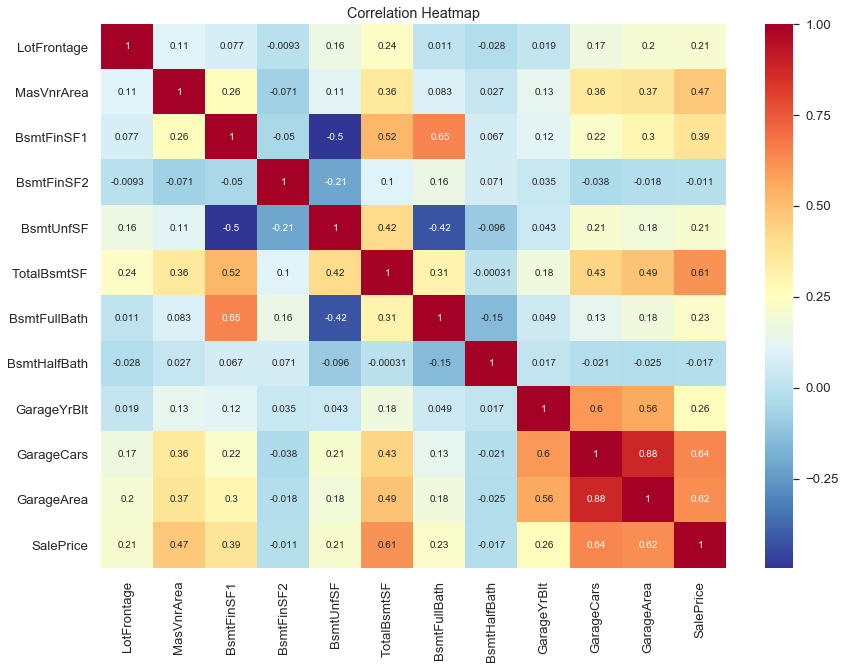

In [34]:
# 計算感興趣的欄位之間的相關係數
corr_df = pd.concat([X_train, y_train], axis=1).corr()
display(corr_df)

# 繪製相關係數的 Heatmap
plt.figure(figsize =(14,10))
sns.heatmap(corr_df, cmap=plt.cm.RdYlBu_r, annot=True)
plt.title('Correlation Heatmap');

In [35]:
# 選擇 Pearson correlation 絕對值高於 0.3 的特徵並返回選擇特徵後的數據
display(abs(corr_df['SalePrice'].drop(labels=['SalePrice'])).sort_values(ascending=False))
corr_threshold = 0.3
corr_selc = corr_df['SalePrice'][(abs(corr_df['SalePrice'])>=corr_threshold) & (corr_df['SalePrice'].index!='SalePrice')].index
house_train_corr_selc = house_train[corr_selc]
print('After Pearson correlation Selection:')
display(house_train_corr_selc.head())

GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
MasVnrArea      0.472614
BsmtFinSF1      0.386420
GarageYrBlt     0.261366
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
LotFrontage     0.209624
BsmtHalfBath    0.016844
BsmtFinSF2      0.011378
Name: SalePrice, dtype: float64

After Pearson correlation Selection:


,MasVnrArea,BsmtFinSF1,TotalBsmtSF,GarageCars,GarageArea
0,196.0,706,856,2,548
1,0.0,978,1262,2,460
2,162.0,486,920,2,608
3,0.0,216,756,3,642
4,350.0,655,1145,3,836


In [36]:
# 選擇 variance 高於 10000 的特徵並返回選擇特徵後的數據
display(X_train.var().sort_values(ascending=False))
var_selc = VarianceThreshold(threshold=10000).fit(X_train)
mask = var_selc.get_support(indices=True)  # Get column names after variance selection
house_train_var_selc = house_train[house_train[float_features].columns[mask]]
print('After Variance Selection:')
display(house_train_var_selc.head())

BsmtFinSF1      208025.468469
GarageYrBlt     205841.235844
BsmtUnfSF       195246.406179
TotalBsmtSF     192462.361709
GarageArea       45712.510229
MasVnrArea       32663.829316
BsmtFinSF2       26023.907779
LotFrontage       1201.613988
GarageCars           0.558480
BsmtFullBath         0.269268
BsmtHalfBath         0.057003
dtype: float64

After Variance Selection:


,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
0,196.0,706,0,150,856,2003.0,548
1,0.0,978,0,284,1262,1976.0,460
2,162.0,486,0,434,920,2001.0,608
3,0.0,216,0,540,756,1998.0,642
4,350.0,655,0,490,1145,2000.0,836


### 卡方檢驗

In [37]:
# 選擇 K=2 個最好的特徵並返回選擇特徵後的數據
chi2_selc = SelectKBest(chi2, k=2).fit(X_train, y_train)
chi2_scores = pd.DataFrame(list(zip(X_train.columns, chi2_selc.scores_, chi2_selc.pvalues_)), 
                           columns=['feature', 'chi2 score', 'p value']).sort_values(by='chi2 score',ascending=False)
display(chi2_scores)
mask = chi2_selc.get_support(indices=True)  # Get column names after chi2 selection
house_train_chi2_selc = house_train[house_train[float_features].columns[mask]]
print('After Chi2 Selection:')
display(house_train_chi2_selc.head())

,feature,chi2 score,p value
2,BsmtFinSF1,399985.063774,0.000000
3,BsmtFinSF2,368882.725049,0.000000
1,MasVnrArea,288024.120868,0.000000
4,BsmtUnfSF,274751.154951,0.000000
5,TotalBsmtSF,174706.462874,0.000000
10,GarageArea,96184.054050,0.000000
8,GarageYrBlt,82977.641875,0.000000
0,LotFrontage,14407.706880,0.000000
7,BsmtHalfBath,597.224646,0.965873
6,BsmtFullBath,448.324316,1.000000


After Chi2 Selection:


,BsmtFinSF1,BsmtFinSF2
0,706,0
1,978,0
2,486,0
3,216,0
4,655,0


### 最大互信息係數

In [38]:
# 選擇 MIC 高於 0.3 的特徵並返回選擇特徵後的數據
m = MINE()
mic_threshold = 0.3
mic = {}

for col in X_train.columns:
    m.compute_score(X_train[col], y_train)
    mic.update({col: m.mic()})

mic_df = pd.Series(mic).rename('MIC')
display(mic_df.sort_values(ascending=False))
mic_selc = mic_df[mic_df>=mic_threshold].index

house_train_mic_selc = house_train[mic_selc]
print('\nAfter MIC Selection:')
display(house_train_mic_selc.head())

GarageCars      0.406954
GarageArea      0.396720
GarageYrBlt     0.340799
TotalBsmtSF     0.340155
MasVnrArea      0.204713
BsmtFinSF1      0.193518
LotFrontage     0.178493
BsmtUnfSF       0.164439
BsmtFullBath    0.141552
BsmtHalfBath    0.097608
BsmtFinSF2      0.095318
Name: MIC, dtype: float64


After MIC Selection:


,TotalBsmtSF,GarageYrBlt,GarageCars,GarageArea
0,856,2003.0,2,548
1,1262,1976.0,2,460
2,920,2001.0,2,608
3,756,1998.0,3,642
4,1145,2000.0,3,836


### - 包裝法 (Wrapper) -
### 遞歸特徵消除法(RFE)

In [39]:
# 以 RandomForestRegressor 為基模(回歸問題)做遞歸特徵消除法 (RFE) 並返回 5 個選擇後的特徵
rfe_selc = RFE(estimator=RandomForestRegressor(), n_features_to_select=5).fit(X_train, y_train)
rfe_scores = pd.DataFrame(list(zip(X_train.columns, rfe_selc.ranking_)), 
                           columns=['feature', 'ranking']).sort_values(by='ranking')
display(rfe_scores)
mask = rfe_selc.get_support(indices=True)  # Get column names after RFE selection
house_train_rfe_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter RFE Selection:')
display(house_train_rfe_selc.head())

,feature,ranking
2,BsmtFinSF1,1
5,TotalBsmtSF,1
8,GarageYrBlt,1
9,GarageCars,1
10,GarageArea,1
1,MasVnrArea,2
0,LotFrontage,3
4,BsmtUnfSF,4
6,BsmtFullBath,5
3,BsmtFinSF2,6



After RFE Selection:


,BsmtFinSF1,TotalBsmtSF,GarageYrBlt,GarageCars,GarageArea
0,706,856,2003.0,2,548
1,978,1262,1976.0,2,460
2,486,920,2001.0,2,608
3,216,756,1998.0,3,642
4,655,1145,2000.0,3,836


### 交叉遞歸特徵消除法(RFECV)

,feature,ranking,score
0,LotFrontage,1,-4.006023e+09
1,MasVnrArea,1,-3.175981e+09
2,BsmtFinSF1,1,-2.474253e+09
3,BsmtFinSF2,1,-2.437697e+09
4,BsmtUnfSF,1,-2.331296e+09
5,TotalBsmtSF,1,-2.151095e+09
6,BsmtFullBath,1,-2.211126e+09
8,GarageYrBlt,1,-2.165137e+09
9,GarageCars,1,-2.085238e+09
10,GarageArea,1,-2.194870e+09


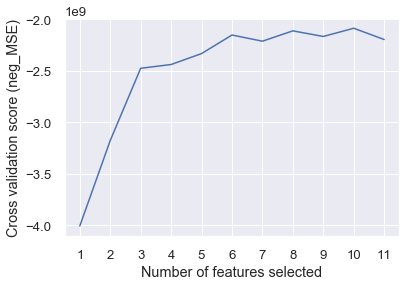


After RFECV Selection:


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706,0,150,856,1,2003.0,2,548
1,80.0,0.0,978,0,284,1262,0,1976.0,2,460
2,68.0,162.0,486,0,434,920,1,2001.0,2,608
3,60.0,0.0,216,0,540,756,1,1998.0,3,642
4,84.0,350.0,655,0,490,1145,1,2000.0,3,836


In [40]:
# 以 RandomForestRegressor 為基模(回歸問題)做遞歸特徵消除法 (RFECV) 並返回選擇後的特徵
rfecv_selc = RFECV(estimator=RandomForestRegressor(), cv=5, 
                   scoring='neg_mean_squared_error', step=1).fit(X_train, y_train)
rfecv_scores = pd.DataFrame(list(zip(X_train.columns, rfecv_selc.ranking_, rfecv_selc.grid_scores_)), 
                            columns=['feature', 'ranking', 'score']).sort_values(by='ranking')
display(rfecv_scores)

plt.figure()
plt.xlabel("Number of features selected");
plt.ylabel("Cross validation score (neg_MSE)");
plt.xticks(range(0, len(rfecv_selc.grid_scores_)+1));
plt.plot(range(1, len(rfecv_selc.grid_scores_)+1), rfecv_selc.grid_scores_);
plt.show()

mask = rfecv_selc.get_support(indices=True)  # Get column names after RFECV selection
house_train_rfecv_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter RFECV Selection:')
display(house_train_rfecv_selc.head())

### - 嵌入法 (Embedded) -
### 正則化

In [41]:
# 帶L1懲罰項的邏輯回歸作為基模型的特徵選擇
lr_reg_l1_selc = SelectFromModel(LogisticRegression(penalty="l1", C=0.001)).fit(X_train, y_train)
mask = lr_reg_l1_selc.get_support(indices=True)  # Get column names after RFE selection
house_train_lr_reg_l1_selc = house_train[house_train[float_features].columns[mask]]
print('After LogisticRegression(L1) Selection:')
display(house_train_lr_reg_l1_selc.head())

# 帶L2懲罰項的邏輯回歸作為基模型的特徵選擇
lr_reg_l2_selc = SelectFromModel(LogisticRegression(penalty="l2", C=0.001)).fit(X_train, y_train)
mask = lr_reg_l2_selc.get_support(indices=True)  # Get column names after RFE selection
house_train_lr_reg_l2_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter LogisticRegression(L2) Selection:')
display(house_train_lr_reg_l2_selc.head())

After LogisticRegression(L1) Selection:


,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
0,196.0,706,0,150,856,2003.0,548
1,0.0,978,0,284,1262,1976.0,460
2,162.0,486,0,434,920,2001.0,608
3,0.0,216,0,540,756,1998.0,642
4,350.0,655,0,490,1145,2000.0,836



After LogisticRegression(L2) Selection:


,LotFrontage,MasVnrArea,GarageArea
0,65.0,196.0,548
1,80.0,0.0,460
2,68.0,162.0,608
3,60.0,0.0,642
4,84.0,350.0,836


### 模型特徵排序

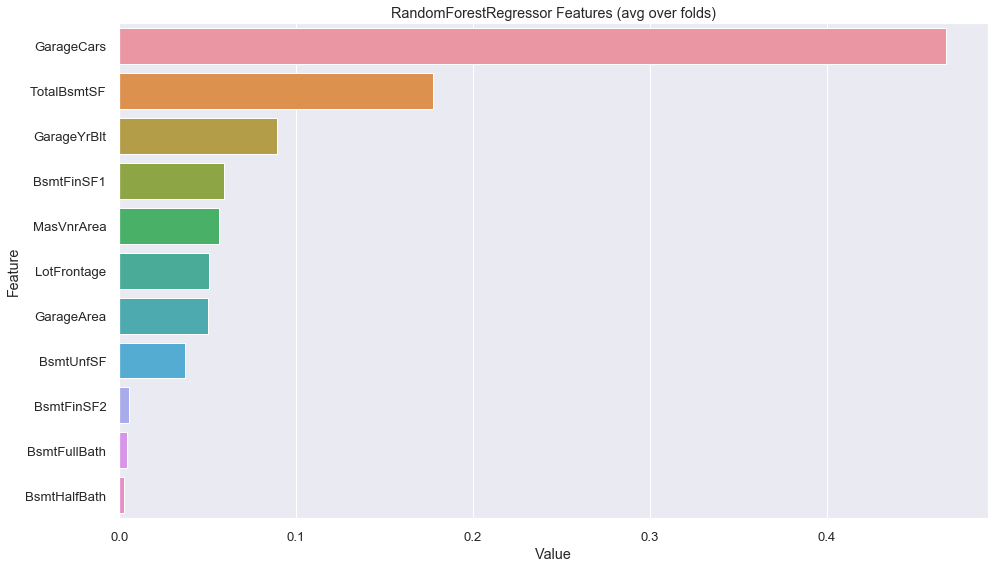

Details: [(0.0025, 'BsmtHalfBath'), (0.0045, 'BsmtFullBath'), (0.00543, 'BsmtFinSF2'), (0.03741, 'BsmtUnfSF'), (0.05018, 'GarageArea'), (0.05082, 'LotFrontage'), (0.05619, 'MasVnrArea'), (0.05893, 'BsmtFinSF1'), (0.08919, 'GarageYrBlt'), (0.17722, 'TotalBsmtSF'), (0.46764, 'GarageCars')]

After RandomForestRegressor Selection:


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706,150,856,2003.0,2,548
1,80.0,0.0,978,284,1262,1976.0,2,460
2,68.0,162.0,486,434,920,2001.0,2,608
3,60.0,0.0,216,540,756,1998.0,3,642
4,84.0,350.0,655,490,1145,2000.0,3,836


In [42]:
# 以 RandomForestRegressor 作為基模型的特徵選擇
# feature_importances_ 視覺化
rf_reg = RandomForestRegressor(n_estimators=500)
rf_reg.fit(X_train, y_train)
feature_imp = pd.DataFrame(sorted(zip(rf_reg.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(14, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForestRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()
print(f"Details: {sorted(zip(np.around(rf_reg.feature_importances_, 5), X_train.columns))}")

# 使用 SelectFromModel 挑選特徵，threshold 預設為 feature_importances_的平均
rf_reg_selc = SelectFromModel(rf_reg, threshold=0.03).fit(X_train, y_train)
mask = rf_reg_selc.get_support(indices=True)  # Get column names after RandomForestRegressor selection
house_train_rf_reg_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter RandomForestRegressor Selection:')
display(house_train_rf_reg_selc.head())

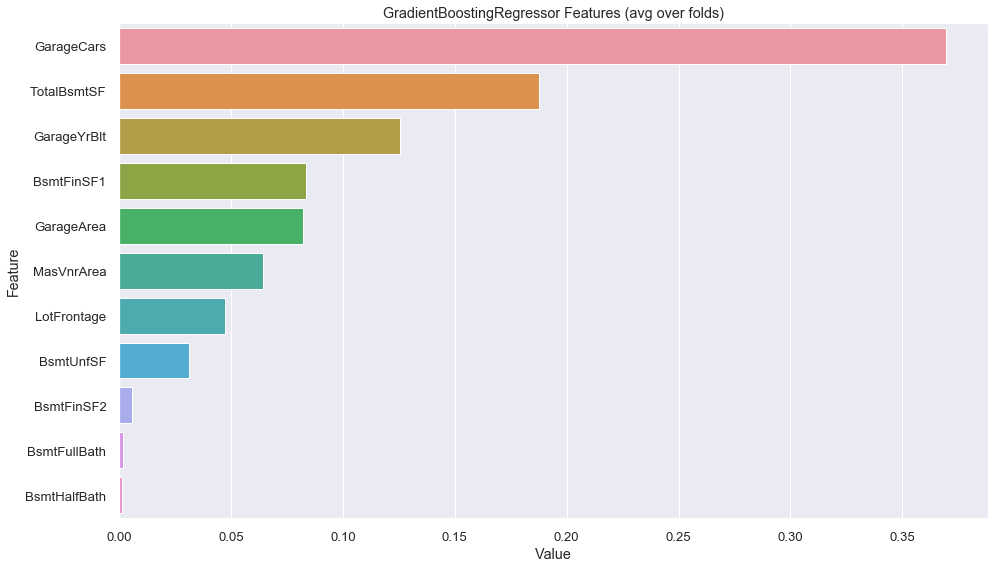

Details: [(0.00135, 'BsmtHalfBath'), (0.00185, 'BsmtFullBath'), (0.00574, 'BsmtFinSF2'), (0.03122, 'BsmtUnfSF'), (0.04742, 'LotFrontage'), (0.06405, 'MasVnrArea'), (0.08192, 'GarageArea'), (0.08364, 'BsmtFinSF1'), (0.12558, 'GarageYrBlt'), (0.18754, 'TotalBsmtSF'), (0.3697, 'GarageCars')]

After GradientBoostingRegressor Selection:


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706,150,856,2003.0,2,548
1,80.0,0.0,978,284,1262,1976.0,2,460
2,68.0,162.0,486,434,920,2001.0,2,608
3,60.0,0.0,216,540,756,1998.0,3,642
4,84.0,350.0,655,490,1145,2000.0,3,836


In [43]:
# 以 GradientBoostingRegressor 作為基模型的特徵選擇
# feature_importances_ 視覺化
gdbt_reg = GradientBoostingRegressor(n_estimators=500)
gdbt_reg.fit(X_train, y_train)
feature_imp = pd.DataFrame(sorted(zip(gdbt_reg.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(14, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('GradientBoostingRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()
print(f"Details: {sorted(zip(np.around(gdbt_reg.feature_importances_, 5), X_train.columns))}")

# 使用 SelectFromModel 挑選特徵，threshold 預設為 feature_importances_的平均
gdbt_reg_selc = SelectFromModel(gdbt_reg, threshold=0.03).fit(X_train, y_train)
mask = gdbt_reg_selc.get_support(indices=True)  # Get column names after RandomForestRegressor selection
house_train_gdbt_reg_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter GradientBoostingRegressor Selection:')
display(house_train_gdbt_reg_selc.head())

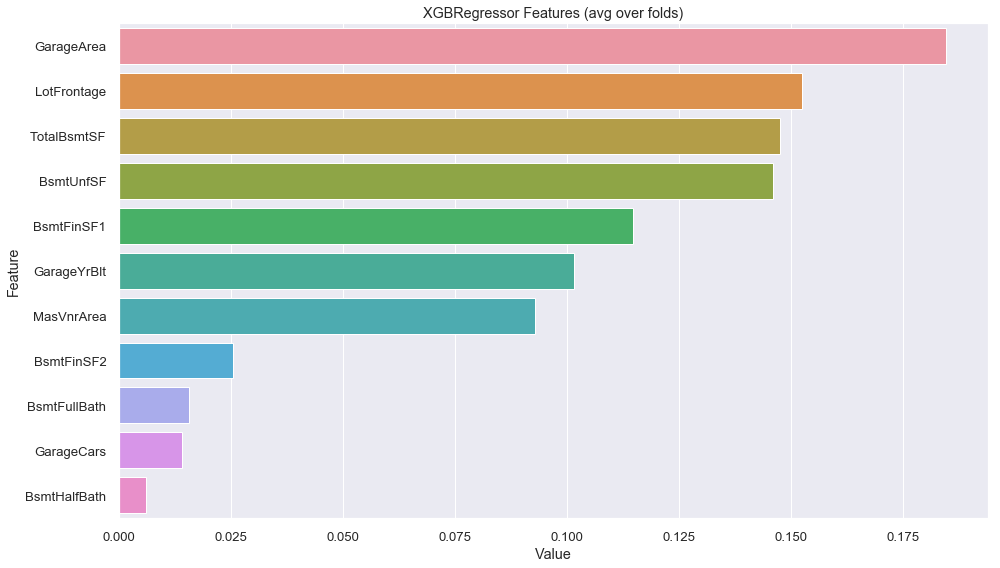

Details: [(0.00588, 'BsmtHalfBath'), (0.01391, 'GarageCars'), (0.01546, 'BsmtFullBath'), (0.02536, 'BsmtFinSF2'), (0.09276, 'MasVnrArea'), (0.10142, 'GarageYrBlt'), (0.11472, 'BsmtFinSF1'), (0.14595, 'BsmtUnfSF'), (0.1475, 'TotalBsmtSF'), (0.15244, 'LotFrontage'), (0.1846, 'GarageArea')]

After XGBRegressor Selection:


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
0,65.0,196.0,706,150,856,2003.0,548
1,80.0,0.0,978,284,1262,1976.0,460
2,68.0,162.0,486,434,920,2001.0,608
3,60.0,0.0,216,540,756,1998.0,642
4,84.0,350.0,655,490,1145,2000.0,836


In [44]:
# 以 XGBRegressor 作為基模型的特徵選擇
# feature_importances_ 視覺化
xgb_reg = XGBRegressor(n_estimators=500)
xgb_reg.fit(X_train, y_train)
feature_imp = pd.DataFrame(sorted(zip(xgb_reg.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(14, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()
print(f"Details: {sorted(zip(np.around(xgb_reg.feature_importances_, 5), X_train.columns))}")

# 使用 SelectFromModel 挑選特徵，threshold 預設為 feature_importances_的平均
xgb_reg_selc = SelectFromModel(xgb_reg, threshold=0.075).fit(X_train, y_train)
mask = xgb_reg_selc.get_support(indices=True)  # Get column names after RandomForestRegressor selection
house_train_xgb_reg_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter XGBRegressor Selection:')
display(house_train_xgb_reg_selc.head())

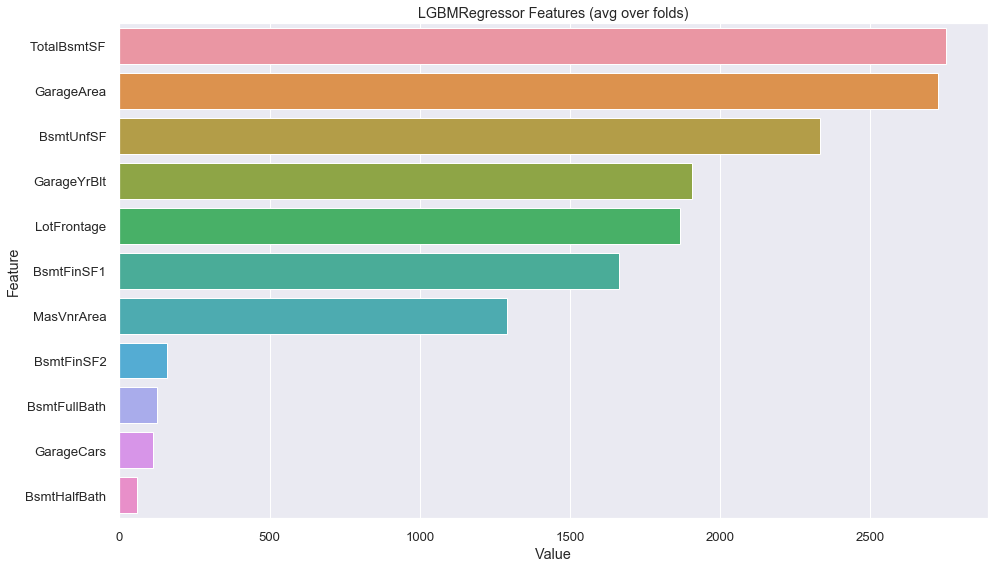

Details: [(59, 'BsmtHalfBath'), (113, 'GarageCars'), (124, 'BsmtFullBath'), (160, 'BsmtFinSF2'), (1292, 'MasVnrArea'), (1665, 'BsmtFinSF1'), (1868, 'LotFrontage'), (1908, 'GarageYrBlt'), (2334, 'BsmtUnfSF'), (2724, 'GarageArea'), (2753, 'TotalBsmtSF')]

After LGBMRegressor Selection:


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
0,65.0,196.0,706,150,856,2003.0,548
1,80.0,0.0,978,284,1262,1976.0,460
2,68.0,162.0,486,434,920,2001.0,608
3,60.0,0.0,216,540,756,1998.0,642
4,84.0,350.0,655,490,1145,2000.0,836


In [45]:
# 以 LGBMRegressor 作為基模型的特徵選擇
# feature_importances_ 視覺化
lgb_reg = LGBMRegressor(n_estimators=500)
lgb_reg.fit(X_train, y_train)
feature_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(14, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBMRegressor Features (avg over folds)')
plt.tight_layout()
plt.show()
print(f"Details: {sorted(zip(lgb_reg.feature_importances_, X_train.columns))}")

# 使用 SelectFromModel 挑選特徵，threshold 預設為 feature_importances_的平均
lgb_reg_selc = SelectFromModel(lgb_reg, threshold=1000).fit(X_train, y_train)
mask = lgb_reg_selc.get_support(indices=True)  # Get column names after LGBMRegressor selection
house_train_lgb_reg_selc = house_train[house_train[float_features].columns[mask]]
print('\nAfter LGBMRegressor Selection:')
display(house_train_lgb_reg_selc.head())